# Scrip para la competencia 01

## EDA y ingeniería de variables

Diagnóstico y explicación del problema: fuga de clientes VIP.

Temas

- Importancia de las variables
- EDA de datos originales, según clase
- Ingeniería de variables
- Segmentación de clientes (según ingresos, operaciones, gastos, etc.)
- Explicabilidad

## Dependencias

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

from joblib import Parallel, delayed

from time import time

import optuna
from optuna.visualization import plot_param_importances, plot_contour, plot_slice, plot_optimization_history

## Directorios

In [3]:
datos = 'datos'

optimizacion = 'optimizacion'

modelos = 'modelos'


## Datos

La creación del target y el análisis exploratorio, está avanzado en el Notebook_comp01.

Se deberá continuar con esto, para diseñar el ejercicio de story-telling sobre "porqué se van los clientes?"

In [4]:
dataset_file = 'competencia_01_brandoni.csv'

dataset_file = os.path.join(datos, dataset_file)

data = pd.read_csv(dataset_file)

Si exploramos la variable foto_mes:

In [5]:
data.foto_mes.value_counts().sort_index()

foto_mes
202101    162026
202102    162646
202103    163685
202104    164090
202105    164623
202106    164876
Name: count, dtype: int64

Vemos que podemos entrenar con predicciones:

- enero a marzo
- febrero a abril
- marzo a mayo
- abril a junio

A continuación se trabaja con **febrero a abril** para entrenar.

Luego, **abril a junio** para testear y validar.

### Condiciones de la prueba

In [6]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202102 # febrero
mes_test = 202104 # abril

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

Función para calcular la ganancia

In [7]:
def ganancia(model, X, y, prop=1, threshold=0.025):

  class_index = np.where(model.classes_ == "BAJA+2")[0][0]
  y_hat = model.predict_proba(X)

  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == "BAJA+2" else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop


Función para seleccionar mes de prueba y separar X del target o del número de cliente

In [8]:
def def_xy(data, mes, target='clase_ternaria', to_pred=False):
    
    X = data[data['foto_mes'] == mes]
    y = X[target]
    X = X.drop(columns=[target])

    numero_de_cliente = X['numero_de_cliente']

    if to_pred:
        return X, numero_de_cliente
    else:
        return X, y

## Importancia de variables

mes_test corresponde al presente, que son los datos más actuales con los que podemos entrenar.

In [9]:
mes_test

202104

In [10]:
# presente
data_pres = data[data['foto_mes'] == mes_test].copy()

# histórico
data_hist = data[data['foto_mes'] < mes_test].copy()

# all data sin últimos meses
data = data[data['foto_mes'] <= mes_test].copy()


### Modelos naive basados en árboles

Para captar relevancia de las variables disponibles originalmente.

In [11]:
X, y = def_xy(data_pres, mes_test)


In [12]:
X.isna().sum().sort_values(ascending=False)[:30]

Master_Finiciomora             163061
Visa_Finiciomora               162679
Master_madelantopesos           98094
Master_mpagospesos              98094
Master_mpagosdolares            98094
Master_mconsumototal            98094
Master_cconsumos                98094
Master_cadelantosefectivo       98094
Master_mconsumosdolares         98094
Master_mconsumospesos           98094
Master_madelantodolares         98094
Visa_madelantopesos             22277
Visa_mpagosdolares              22277
Visa_mconsumosdolares           22277
Visa_mconsumospesos             22277
Visa_madelantodolares           22277
Visa_cadelantosefectivo         22277
Visa_cconsumos                  22277
Visa_mpagospesos                22277
Visa_mconsumototal              22277
Master_fultimo_cierre           16926
Master_mpagado                  16871
Master_fechaalta                16871
Master_delinquency              16871
Master_mlimitecompra            16871
Master_mpagominimo              16871
Master_mfina

Entrenando modelos

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# # Entrenamiento del modelo de Decision Tree
model_dt = DecisionTreeClassifier(criterion='gini',
                                  min_samples_split=80,
                                  min_samples_leaf=1,
                                  max_depth=10,
                                  random_state=17)

model_dt.fit(X, y)

# Entrenamiento del modelo de Random Forest
model_rf = RandomForestClassifier(n_estimators=100, 
                                  max_depth=10, 
                                  random_state=17)

X_imp = X.fillna(0)

model_rf.fit(X_imp, y)

RandomForestClassifier(max_depth=10, random_state=17)

Guardando modelos

In [14]:
import pickle

filename = 'modelos/model_dt_ori_eda.sav'

with open(filename, 'wb') as file:
    pickle.dump(model_dt, file)

print(f'Modelo guardado como {filename}')

filename = 'modelos/model_rf_ori_eda.sav'

with open(filename, 'wb') as file:
    pickle.dump(model_rf, file)

print(f'Modelo guardado como {filename}')

Modelo guardado como modelos/model_dt_ori_eda.sav
Modelo guardado como modelos/model_rf_ori_eda.sav


Leyendo los modelos guardados

In [15]:
filename = 'modelos/model_dt_ori_eda.sav'
model_dt = pickle.load(open(filename, 'rb'))

filename = 'modelos/model_rf_ori_eda.sav'
model_rf = pickle.load(open(filename, 'rb'))

In [16]:
model_dt

DecisionTreeClassifier(max_depth=10, min_samples_split=80, random_state=17)

In [17]:
# Importancia de características con Decision Tree
feature_importances_dt = pd.DataFrame({'feature': X.columns, 'importance': model_dt.feature_importances_})
feature_importances_dt.sort_values('importance', ascending=False, inplace=True)

# Importancia de características con Random Forest
feature_importances_rf = pd.DataFrame({'feature': X.columns, 'importance': model_rf.feature_importances_})
feature_importances_rf.sort_values('importance', ascending=False, inplace=True)

Normalizamos la importancia de ambos modelos

In [18]:
# DecisionTree
feature_importances_dt.fillna(0, inplace=True)
feature_importances_dt.importance = feature_importances_dt.importance/feature_importances_dt.importance.sum()

# RandomForest
feature_importances_rf.fillna(0, inplace=True)
feature_importances_rf.importance = feature_importances_rf.importance/feature_importances_rf.importance.sum()

In [19]:
# Seleccionar las 20 características más importantes en ambos modelos
top_features_dt = feature_importances_dt.head(20)
top_features_rf = feature_importances_rf.head(20)

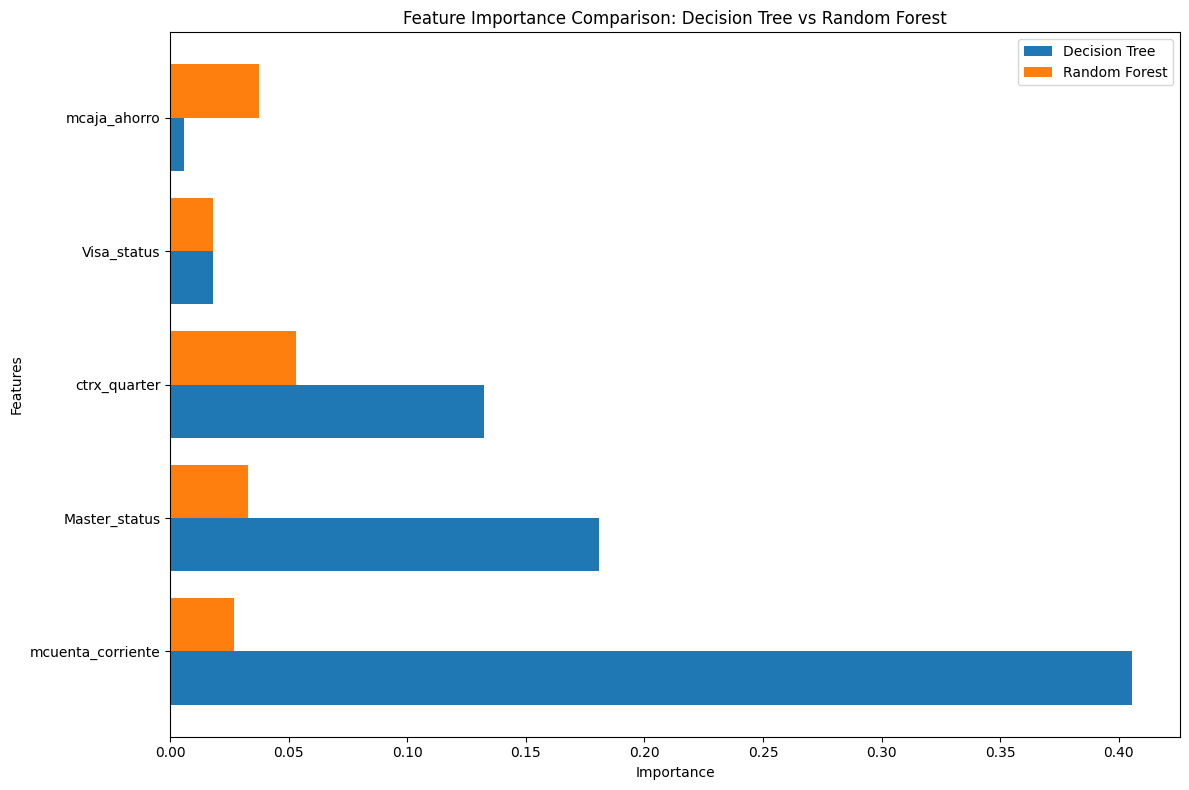

In [20]:
# Combinar los resultados en un solo DataFrame para facilitar la comparación
comparison_df = pd.merge(top_features_dt, top_features_rf, on='feature', suffixes=('_dt', '_rf'))

# Gráfico de barras doble con ejes invertidos
plt.figure(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(comparison_df))

plt.barh(index, comparison_df['importance_dt'], bar_width, label='Decision Tree')
plt.barh(index + bar_width, comparison_df['importance_rf'], bar_width, label='Random Forest')

plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance Comparison: Decision Tree vs Random Forest')
plt.yticks(index + bar_width / 2, comparison_df['feature'])
plt.legend()

plt.tight_layout()
plt.show()

Se percibe notoria diferencia en la medición de importancia entre dt y rf

In [21]:
top_features_dt.importance.sum()

0.9988211060653447

In [22]:
top_features_rf.importance.sum()

0.508100641069389

El algoritmo de rf es mucho más democrático a la hora de asignar relevancia a las features

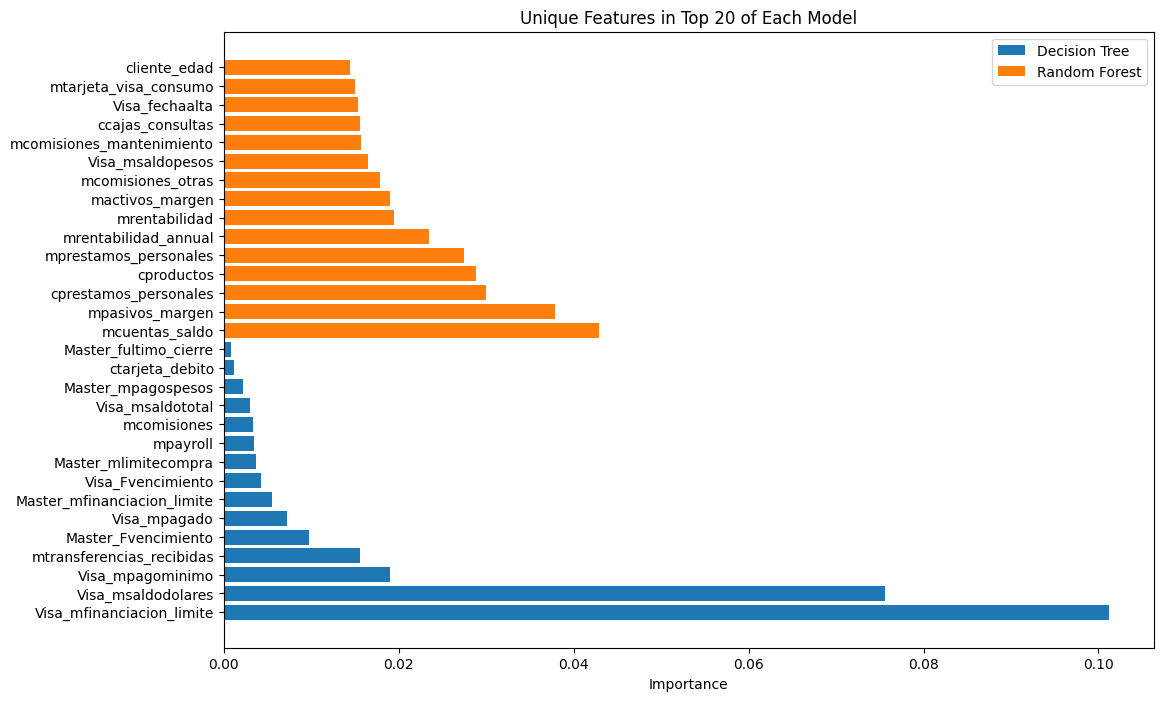

In [23]:
# Variables en el top 20 del Decision Tree
top_features_dt_set = set(top_features_dt['feature'])

# Variables en el top 20 del Random Forest
top_features_rf_set = set(top_features_rf['feature'])

# Variables en el top 20 del Decision Tree pero no en el Random Forest
only_in_dt = top_features_dt_set - top_features_rf_set

# Variables en el top 20 del Random Forest pero no en el Decision Tree
only_in_rf = top_features_rf_set - top_features_dt_set

# Crear DataFrames con las diferencias
only_in_dt_df = feature_importances_dt[feature_importances_dt['feature'].isin(only_in_dt)]
only_in_rf_df = feature_importances_rf[feature_importances_rf['feature'].isin(only_in_rf)]

# Combinando las diferencias en un solo DataFrame
combined_df = pd.concat([
    only_in_dt_df.assign(model='Decision Tree'),
    only_in_rf_df.assign(model='Random Forest')
])

# Gráfico combinado de barras
plt.figure(figsize=(12, 8))

# Graficar las barras, con color por modelo
for model in combined_df['model'].unique():
    subset = combined_df[combined_df['model'] == model]
    plt.barh(subset['feature'], subset['importance'], label=model)

# Configuraciones del gráfico
plt.xlabel('Importance')
plt.title('Unique Features in Top 20 of Each Model')
plt.legend()
# plt.grid(True)
plt.show()

Resulta que los diferentes métodos tienen, en sus top20, diferentes "mejores variables" Solo coinciden en 5 de ellas.  

In [24]:
combinacion_top = top_features_dt_set | top_features_rf_set

Aunque tomo la combinación de ambas, me quedo con la importancia que asigna únicamente rf

In [25]:
features = feature_importances_rf[feature_importances_rf['feature'].isin(combinacion_top)]

In [26]:
features

,feature,importance
107,ctrx_quarter,0.053022
22,mcuentas_saldo,0.042892
11,mpasivos_margen,0.037819
18,mcaja_ahorro,0.037494
111,Master_status,0.032970
32,cprestamos_personales,0.029948
12,cproductos,0.028879
33,mprestamos_personales,0.027473
16,mcuenta_corriente,0.027076
8,mrentabilidad_annual,0.023460


# EDA

Análisis sobre las variables de mayor importancia

Simplificando la clase para el análisis

In [27]:
data['clase_bin'] = np.where(data['clase_ternaria'] == 'CONTINUA', 'CONTINUA', 'BAJA')

data_pres['clase_bin'] = np.where(data_pres['clase_ternaria'] == 'CONTINUA', 'CONTINUA', 'BAJA')

data_hist['clase_bin'] = np.where(data_hist['clase_ternaria'] == 'CONTINUA', 'CONTINUA', 'BAJA')

Adaptando variables para mejorar su visualización y análisis

In [28]:
def convert_to_float(df, columns):
    df[columns] = df[columns].astype(float)
    return df

def convert_to_int(df, columns):
    df[columns] = df[columns].fillna(0).astype(int)    
    return df

def cut_high_5(df, columns, quantile=0.95):
    for col in columns:
        high_cutoff = df[col].quantile(quantile)
        df = df[df[col] <= high_cutoff]
    return df

def cut_high_10(df, columns, quantile=0.9):
    for col in columns:
        high_cutoff = df[col].quantile(quantile)
        df = df[df[col] <= high_cutoff]
    return df

def cut_low_5(df, columns, quantile=0.05):
    for col in columns:
        low_cutoff = df[col].quantile(quantile)
        df = df[df[col] >= low_cutoff]
    return df

def cut_low_10(df, columns, quantile=0.1):
    for col in columns:
        low_cutoff = df[col].quantile(quantile)
        df = df[df[col] >= low_cutoff]
    return df

# Cut 5% of lower and higher samples
def cut_low_high(df, columns, low_quantile=0.05, high_quantile=0.95):
    for col in columns:
        low_cutoff = df[col].quantile(low_quantile)
        high_cutoff = df[col].quantile(high_quantile)
        df = df[(df[col] >= low_cutoff) & (df[col] <= high_cutoff)]
    return df

# Apply logarithmic transformation
def apply_log_transform(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])  # log1p is used to avoid issues with log(0)
    return df

def adapt_columns(df, to_float, to_int, to_cut_high_5,
                  to_cut_high_10, to_cut_low_5, to_cut_low_10, 
                  to_cut_low_high, to_log_transform=[]):
    
    # Convert columns to float
    df = convert_to_float(df, to_float)
    
    # Convert columns to integer
    df = convert_to_int(df, to_int)
    
    # Cut 5% of higher samples
    df = cut_high_5(df, to_cut_high_5)

    # Cut 10% of higher samples
    df = cut_high_10(df, to_cut_high_10)

    # Cut 10% of lower and higher samples
    df = cut_low_5(df, to_cut_low_5)

    # Cut 10% of lower and higher samples
    df = cut_low_10(df, to_cut_low_10)
    
    # Cut 5% of lower and higher samples
    df = cut_low_high(df, to_cut_low_high)
       
    return df

In [29]:
to_float = ['ctrx_quarter', 
            'ccajas_consultas',
            'cliente_edad',
            'ctarjeta_debito']

to_int = ['cprestamos_personales', 'cproductos', 'Master_status']

to_cut_high_5 = ['ctrx_quarter', 
                  'mcaja_ahorro', 
                  'cprestamos_personales'] # 5 % of higher samples

to_cut_high_10 = ['mprestamos_personales']

to_cut_low_5 = ['mcuenta_corriente']

to_cut_low_10 = []

to_cut_low_high = ['mcuentas_saldo', 
                   'mpasivos_margen', 
                   'mrentabilidad_annual'] # 5 % of lower and higher samples

to_log = ['mcuentas_saldo',
          'mcuenta_corriente', 
          'mprestamos_personales']

data = adapt_columns(data, to_float, to_int, 
                     to_cut_high_5, to_cut_high_10, to_cut_low_5,
                     to_cut_low_10, to_cut_low_high)

data_pres = adapt_columns(data_pres, to_float, to_int, 
                        to_cut_high_5, to_cut_high_10, to_cut_low_5,
                        to_cut_low_10, to_cut_low_high)

data_hist = adapt_columns(data_hist, to_float, to_int, 
                        to_cut_high_5, to_cut_high_10, to_cut_low_5,
                        to_cut_low_10, to_cut_low_high)

Funciones para el análisis

In [30]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [31]:
import seaborn as sns

def summary_statistics(data):
    return data.describe().T.to_markdown()

def summary_statistics_comparative(data1, data2, key1='1', key2='2'):
    summary1 = data1.describe().T
    summary2 = data2.describe().T
    summary_combined = pd.concat([summary1, summary2], axis=1, keys=[key1, key2])
    
    stats = summary1.columns.tolist()
    
    new_columns = []
    for stat in stats:
        new_columns.extend([(key1, stat), (key2, stat)])
    
    summary_combined = summary_combined.reindex(columns=new_columns)
    
    return summary_combined

def is_int(data, feature):
    if pd.api.types.is_numeric_dtype(data[feature]):
        if pd.api.types.is_integer_dtype(data[feature]):
            return True
        else:
            return False

def plot_distributions(data, num_features, target, title_suffix='', sample_frac=0.2, transform='log1p', to_log=[]):
    """Plot distributions of numerical features, determining if they are discrete or continuous,
    and sample the dataset to speed up the process. Apply appropriate transformation to continuous variables."""
    
    data_sampled = data.sample(frac=sample_frac, random_state=42)
    
    for feature in num_features:
        plt.figure(figsize=(10, 4))

        palette = {'CONTINUA': sns.color_palette()[0], 'BAJA': sns.color_palette()[1]}

        # Determine if the feature is discrete or continuous
        if is_int(data_sampled, feature):
            # Obtenemos las clases únicas del target
            target_classes = data_sampled[target].unique()
            
            # Lista para almacenar los DataFrames de frecuencias relativas
            freq_data_list = []
            
            # Calculamos la frecuencia relativa de feature para cada clase del target
            for t_class in target_classes:
                # Filtramos los datos por la clase del target
                data_tclass = data_sampled[data_sampled[target] == t_class]
                
                # Calculamos la frecuencia relativa de cada categoría de feature
                counts = data_tclass[feature].value_counts(normalize=True).reset_index()
                counts.columns = [feature, 'relative_freq']
                counts[target] = t_class  # Añadimos la clase del target
                
                # Añadimos al listado
                freq_data_list.append(counts)
            
            # Concatenamos los DataFrames
            freq_data = pd.concat(freq_data_list, ignore_index=True)
            
            # Graficamos las frecuencias relativas
            sns.barplot(x=feature, y='relative_freq', hue=target, data=freq_data, palette=palette)
            
            # Añadimos etiquetas y título
            plt.title(f'Relative Frequency Plot of {feature} {title_suffix}')
            plt.ylabel('Relative Frequency')

            plt.show()
            
        else:
            if feature in to_log:
                # Handle NaN and negative values before applying log1p
                if transform == 'log1p':
                    positive_values = data_sampled[feature] > 0
                    transformed_feature = np.log1p(data_sampled[feature].where(positive_values))
                    title_t = f'Log1p-Transformed Distribution of {feature} {title_suffix}'
                    x_label = f'Log1p({feature})'
                elif transform == 'sqrt':
                    non_negative_values = data_sampled[feature] - data_sampled[feature].min() + 1
                    transformed_feature = np.sqrt(non_negative_values)
                    title_t = f'Square Root Transformed Distribution of {feature} {title_suffix}'
                    x_label = f'Square Root({feature})'
                
                # Normal plot
                title = f'Distribution of {feature} {title_suffix}'
                df_ = pd.DataFrame({feature: data_sampled[feature], target: data_sampled[target]})
                sns.histplot(data=df_, x=feature, hue=target, kde=True, element='step', stat="probability", 
                            common_norm=False, palette=palette)
                plt.title(title)

                plt.show()

                # Transformed plot
                df_transformed = pd.DataFrame({feature: transformed_feature, target: data_sampled[target]})
                sns.histplot(data=df_transformed, x=feature, hue=target, kde=True, element='step', stat="probability", 
                            common_norm=False, palette=palette)
                plt.title(title_t)
                plt.xlabel(x_label)

                plt.show()

            else:
                title = f'Distribution of {feature} {title_suffix}'
                df_ = pd.DataFrame({feature: data_sampled[feature], target: data_sampled[target]})
                sns.histplot(data=df_, x=feature, hue=target, kde=True, element='step', stat="probability", 
                            common_norm=False, palette=palette)
                plt.title(title)

                plt.show()
        
def plot_correlation_matrix(data, target=None, title_suffix=''):
    data_ = data.copy()
    # Encode the target variable if provided
    if target:
        data_[target] = data_[target].map({"CONTINUA": 0, "BAJA": 1}).astype(float)

        numeric_data = data_.select_dtypes(include=[np.number])
    else:
        numeric_data = data_.select_dtypes(include=[np.number])
    
    # Compute the correlation matrix
    corr_matrix = numeric_data.corr()
    
    # Plot the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
    plt.title(f'Correlation Matrix {title_suffix}')
    plt.show()

def missing_values_analysis(data_):
    missing_values = data_.isnull().mean() * 100
    return missing_values[missing_values > 0].sort_values(ascending=False)

In [33]:
list(features.feature)[:10]

['ctrx_quarter',
 'mcuentas_saldo',
 'mpasivos_margen',
 'mcaja_ahorro',
 'Master_status',
 'cprestamos_personales',
 'cproductos',
 'mprestamos_personales',
 'mcuenta_corriente',
 'mrentabilidad_annual']

Summary Statistics - All Data
|                       |   count |           mean |          std |       min |     25% |       50% |       75% |       max |
|:----------------------|--------:|---------------:|-------------:|----------:|--------:|----------:|----------:|----------:|
| ctrx_quarter          |  351734 |    99.6842     |    58.0811   |      0    |   54    |    93     |    138    |    268    |
| mcuentas_saldo        |  351734 | 71732          | 94710.7      |  -5324.34 | 3985.51 | 34231.1   | 103137    | 519572    |
| mpasivos_margen       |  351734 |   814.379      |   707.715    |      2.98 |  272.01 |   607.045 |   1161.66 |   3207.29 |
| mcaja_ahorro          |  351734 | 41048.7        | 46273.2      |  -4249.56 | 8154.91 | 24603.2   |  56849.9  | 288770    |
| Master_status         |  351734 |     0.00840408 |     0.269113 |      0    |    0    |     0     |      0    |      9    |
| cprestamos_personales |  351734 |     0.141559   |     0.493785 |      0    |    0    

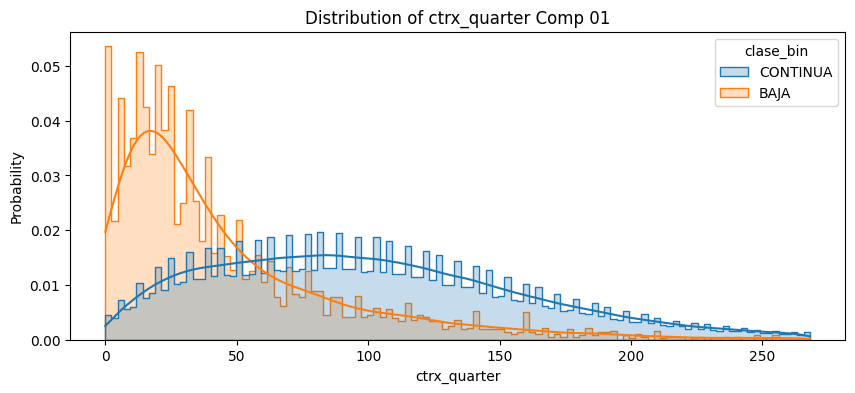

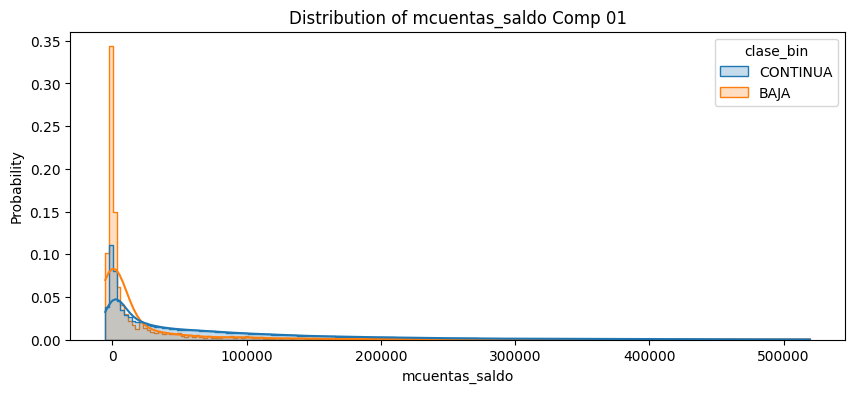

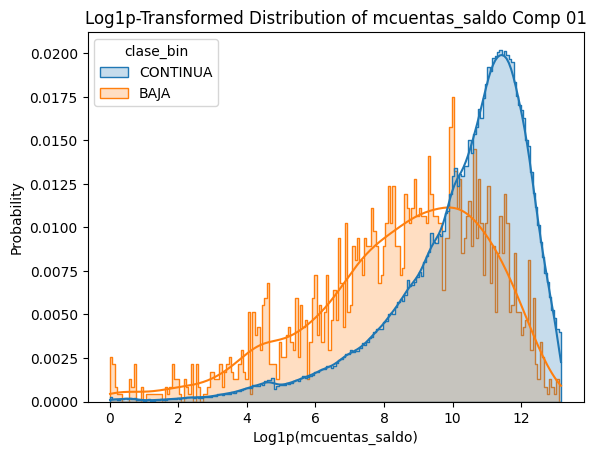

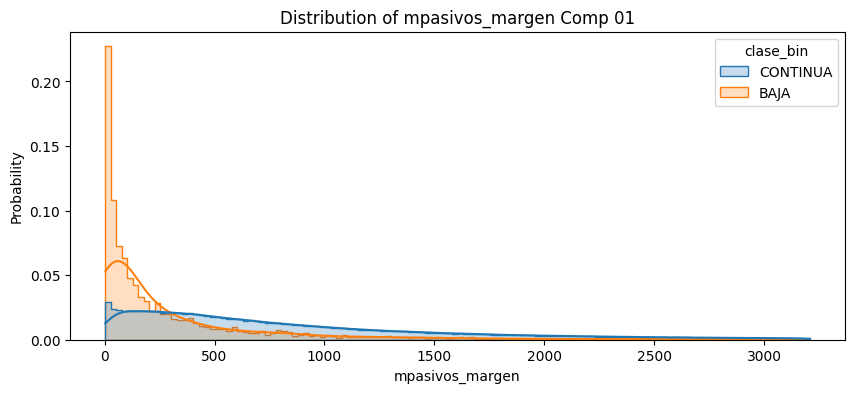

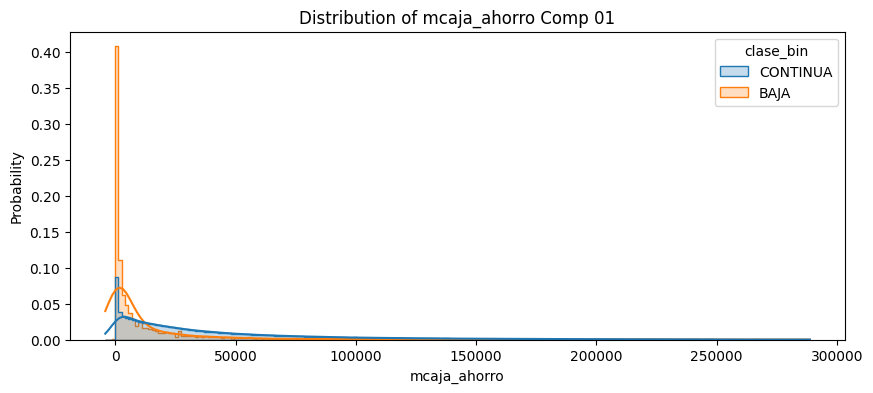

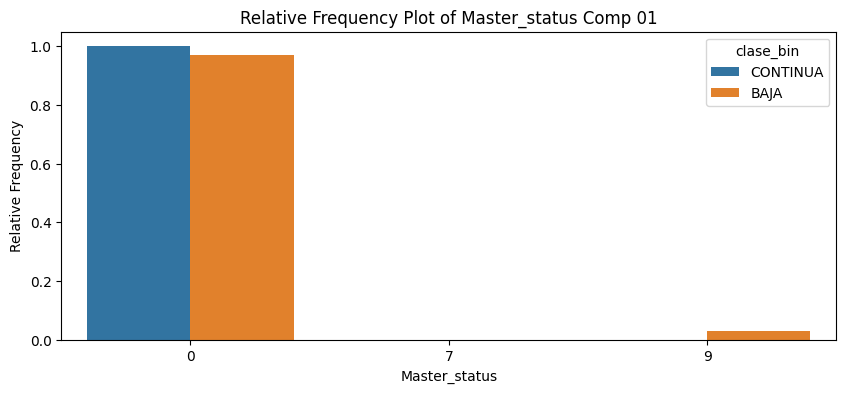

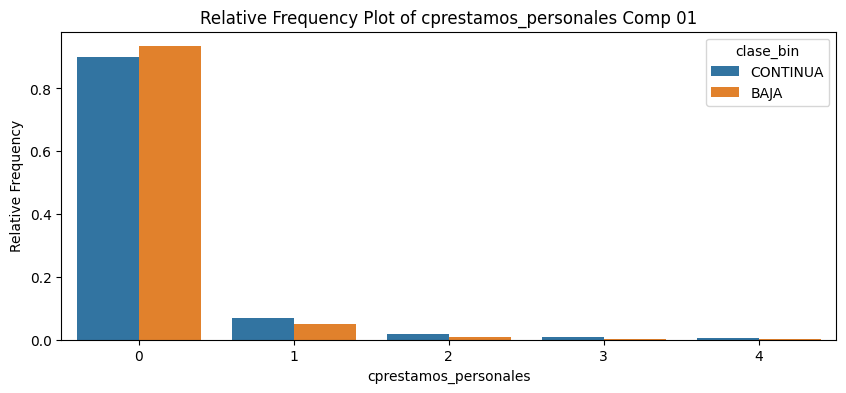

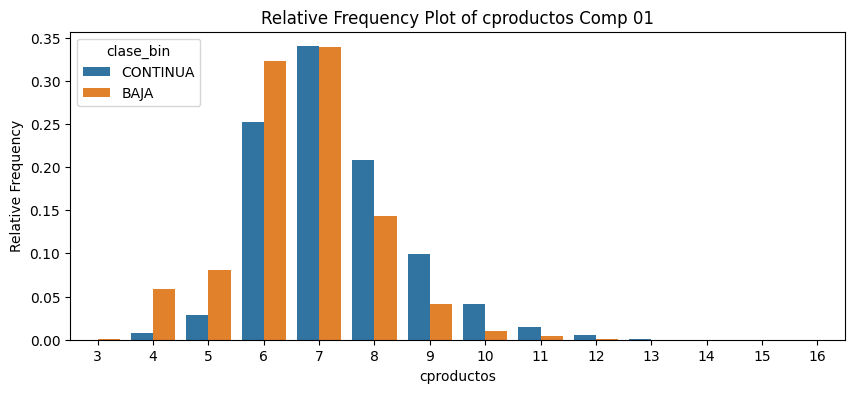

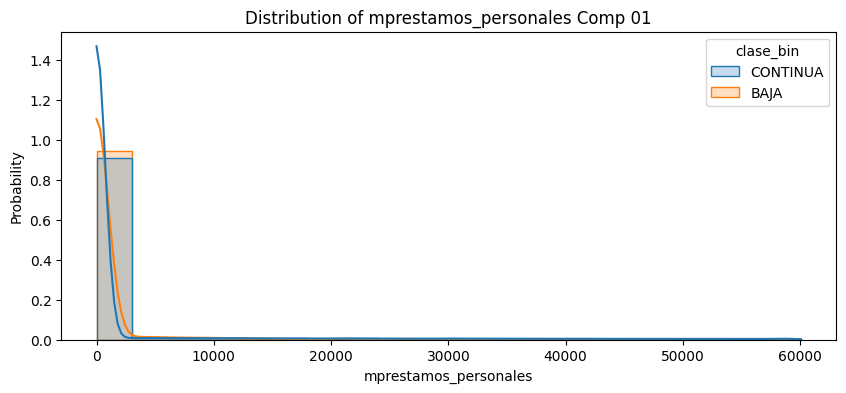

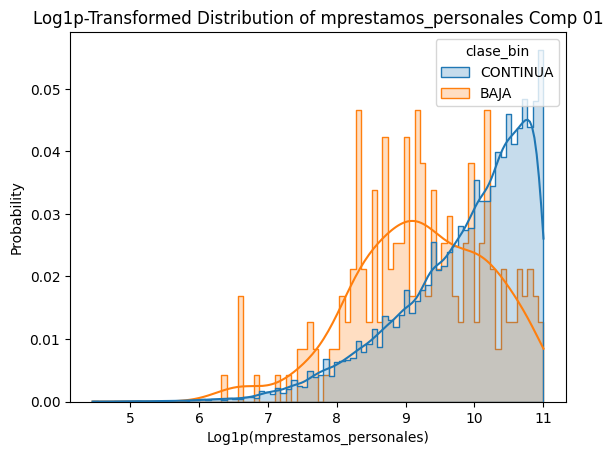

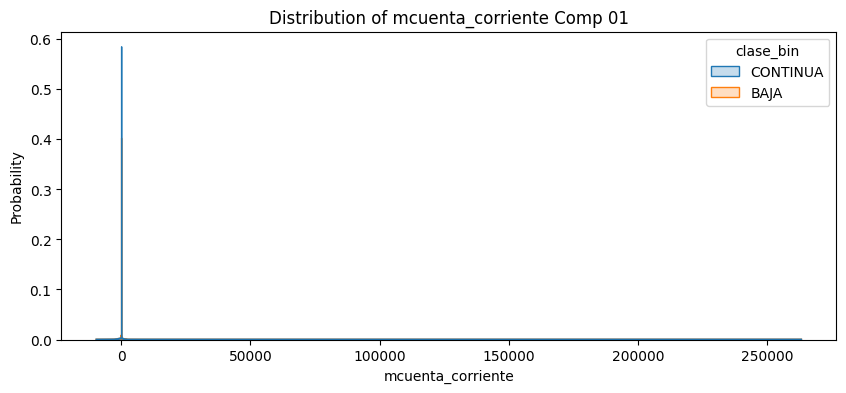

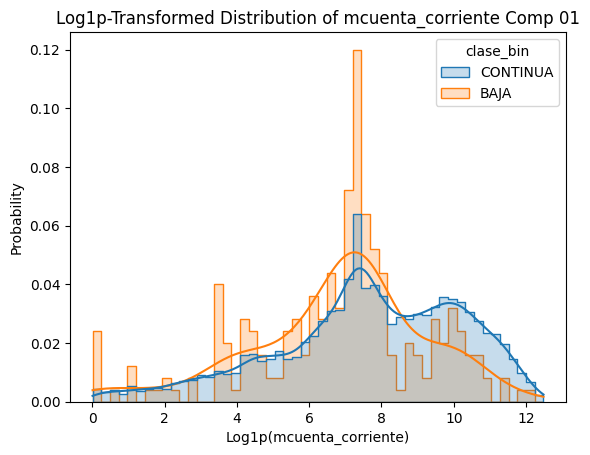

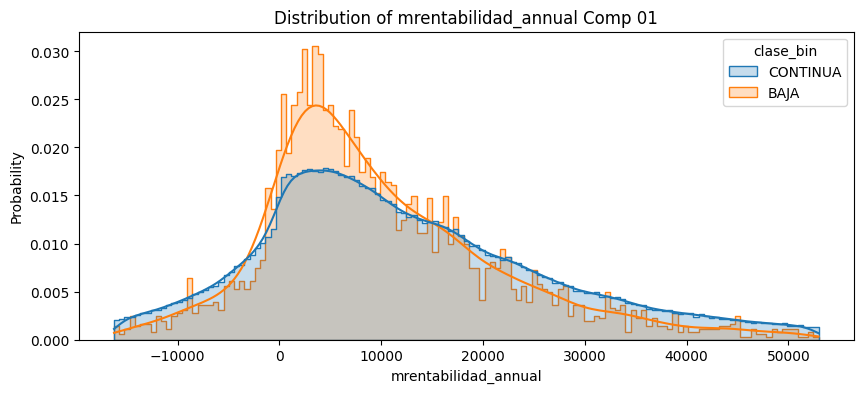

Correlation Matrix - 202104 Data


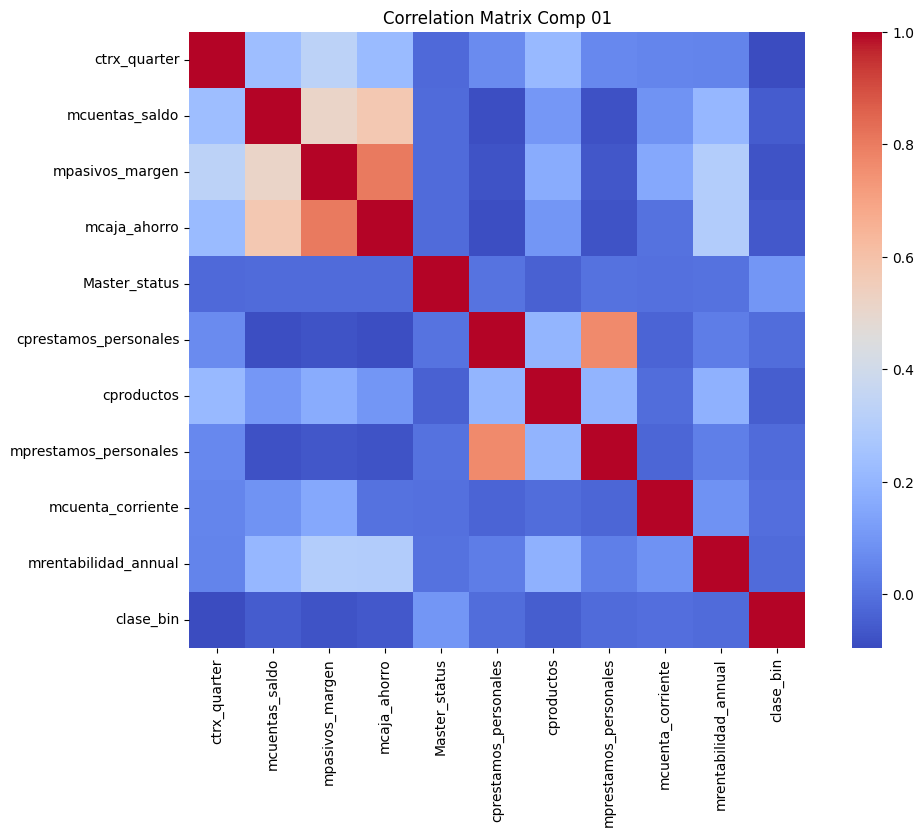

Missing Values - 202104 Data
Series([], dtype: float64)


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

target = 'clase_bin'  # Your target variable

# Assuming you have your list of the top 10 original relevant variables + target
top_features_with_target = list(features.feature)[:10] + [target]

# Selecting top columns
data_top = data[top_features_with_target]

# Summary statistics
print("Summary Statistics - All Data")
print(summary_statistics(data_top))
print()

print("Resumen Estadístico - Comparativo")
key1= 'BAJA'
key2= 'CONTINUA'
summary_stats_combined = summary_statistics_comparative(data_top.loc[data_top.clase_bin == key1], 
                                                        data_top.loc[data_top.clase_bin == key2], 
                                                        key1, key2)
print(summary_stats_combined.to_markdown())

# Distribution of numerical features
numeric_features = data_top.select_dtypes(include=[np.number]).columns.tolist()

print("Distribution of Numerical Features - All Data")
plot_distributions(data_top, numeric_features, 
                   target=target, title_suffix='Comp 01', 
                   transform='log1p', sample_frac=1, to_log=to_log)

# Correlation Matrix
print("Correlation Matrix - 202104 Data")
plot_correlation_matrix(data_top, target=target, title_suffix='Comp 01')

# Missing Values Analysis
print("Missing Values - 202104 Data")
print(missing_values_analysis(data_top))

Presente vs. Histórico

In [35]:
def is_int(data, feature):
    if pd.api.types.is_numeric_dtype(data[feature]):
        return pd.api.types.is_integer_dtype(data[feature])
    else:
        return False

def transform_feature(data_sampled, feature, transform):
    if transform == 'log1p':
        positive_values = data_sampled[feature] > 0
        transformed_feature = np.log1p(data_sampled[feature].where(positive_values))
    elif transform == 'sqrt':
        non_negative_values = data_sampled[feature] - data_sampled[feature].min() + 1
        transformed_feature = np.sqrt(non_negative_values)
    else:
        transformed_feature = data_sampled[feature]
    return transformed_feature

def plot_distributions_comparative(data1, data2, num_features, target, sample_frac=0.2, transform='log1p', to_log=[]):
    """Plot distributions of numerical features for two datasets side by side,
    applying transformations as specified."""
    data1_sampled = data1.sample(frac=sample_frac, random_state=42).copy()
    data2_sampled = data2.sample(frac=sample_frac, random_state=42).copy()
    
    # Ensure target variable is of consistent type (convert to string)
    data1_sampled[target] = data1_sampled[target].astype(str)
    data2_sampled[target] = data2_sampled[target].astype(str)
    
    for feature in num_features:
        is_discrete = is_int(data1_sampled, feature)
        apply_transform = (feature in to_log) and not is_discrete
        if apply_transform:
            nrows = 2
        else:
            nrows = 1
        fig, axes = plt.subplots(nrows, 2, figsize=(16, 6*nrows))
        
        # Ensure axes is a 2D array for consistent indexing
        if nrows == 1:
            axes = np.array([axes])
        
        # Get unique target classes and define palette
        target_classes = data1_sampled[target].unique()
        target_classes_pres = data2_sampled[target].unique()

        # Create a palette mapping each target class to a color
        palette = {'CONTINUA': sns.color_palette()[0], 'BAJA': sns.color_palette()[1]}

        # Histórico - Original Distribution
        ax = axes[0, 0]
        if is_discrete:
            freq_data_list = []
            for t_class in target_classes:
                data_tclass = data1_sampled[data1_sampled[target] == t_class]
                counts = data_tclass[feature].value_counts(normalize=True).reset_index()
                counts.columns = [feature, 'relative_freq']
                counts[target] = t_class
                freq_data_list.append(counts)
            freq_data = pd.concat(freq_data_list, ignore_index=True)
            sns.barplot(x=feature, y='relative_freq', hue=target, data=freq_data, palette=palette, ax=ax)
            ax.set_title(f'{feature} Distribution (Histórico - Original)')
            ax.set_ylabel('Relative Frequency')
        else:
            df_ = pd.DataFrame({feature: data1_sampled[feature], target: data1_sampled[target]})
            sns.histplot(data=df_, x=feature, hue=target, kde=True, element='step', 
                         stat="probability", common_norm=False, ax=ax, palette=palette)
            ax.set_title(f'{feature} Distribution (Histórico - Original)')
        
        # Presente - Original Distribution
        ax = axes[0, 1]
        if is_discrete:
            freq_data_list = []
            for t_class in target_classes_pres:
                data_tclass = data2_sampled[data2_sampled[target] == t_class]
                counts = data_tclass[feature].value_counts(normalize=True).reset_index()
                counts.columns = [feature, 'relative_freq']
                counts[target] = t_class
                freq_data_list.append(counts)
            freq_data = pd.concat(freq_data_list, ignore_index=True)
            sns.barplot(x=feature, y='relative_freq', hue=target, data=freq_data, palette=palette, ax=ax)
            ax.set_title(f'{feature} Distribution (Presente - Original)')
            ax.set_ylabel('Relative Frequency')
        else:
            df_ = pd.DataFrame({feature: data2_sampled[feature], target: data2_sampled[target]})
            sns.histplot(data=df_, x=feature, hue=target, kde=True, element='step', 
                         stat="probability", common_norm=False, ax=ax, palette=palette)
            ax.set_title(f'{feature} Distribution (Presente - Original)')
        
        if apply_transform:
            # Histórico - Transformed Distribution
            ax = axes[1, 0]
            if transform == 'log1p':
                positive_values = data1_sampled[feature] > 0
                transformed_feature = np.log1p(data1_sampled.loc[positive_values, feature])
                df_transformed = pd.DataFrame({
                    feature: transformed_feature, 
                    target: data1_sampled.loc[positive_values, target]
                })
                title_t = f'Log1p-Transformed Distribution of {feature} (Histórico)'
                x_label = f'Log1p({feature})'
            elif transform == 'sqrt':
                non_negative_values = data1_sampled[feature] - data1_sampled[feature].min() + 1
                transformed_feature = np.sqrt(non_negative_values)
                df_transformed = pd.DataFrame({feature: transformed_feature, target: data1_sampled[target]})
                title_t = f'Square Root Transformed Distribution of {feature} (Histórico)'
                x_label = f'Square Root({feature})'
            sns.histplot(data=df_transformed, x=feature, hue=target, kde=True, element='step', 
                         stat="probability", common_norm=False, ax=ax, palette=palette)
            ax.set_title(title_t)
            ax.set_xlabel(x_label)
            
            # Presente - Transformed Distribution
            ax = axes[1, 1]
            if transform == 'log1p':
                positive_values = data2_sampled[feature] > 0
                transformed_feature = np.log1p(data2_sampled.loc[positive_values, feature])
                df_transformed = pd.DataFrame({
                    feature: transformed_feature, 
                    target: data2_sampled.loc[positive_values, target]
                })
                title_t = f'Log1p-Transformed Distribution of {feature} (Presente)'
                x_label = f'Log1p({feature})'
            elif transform == 'sqrt':
                non_negative_values = data2_sampled[feature] - data2_sampled[feature].min() + 1
                transformed_feature = np.sqrt(non_negative_values)
                df_transformed = pd.DataFrame({feature: transformed_feature, target: data2_sampled[target]})
                title_t = f'Square Root Transformed Distribution of {feature} (Presente)'
                x_label = f'Square Root({feature})'
            sns.histplot(data=df_transformed, x=feature, hue=target, kde=True, element='step', 
                         stat="probability", common_norm=False, ax=ax, palette=palette)
            ax.set_title(title_t)
            ax.set_xlabel(x_label)
                
        plt.tight_layout()
        plt.show()

def plot_correlation_matrix_comparative(data1, data2, target=None):
    data1_ = data1.copy()
    data2_ = data2.copy()
    
    # Encode the target variable if provided
    if target:
        data1_[target] = data1_[target].map({"CONTINUA": 0, "BAJA": 1}).astype(float)
        data2_[target] = data2_[target].map({"CONTINUA": 0, "BAJA": 1}).astype(float)
    
    numeric_data1 = data1_.select_dtypes(include=[np.number])
    numeric_data2 = data2_.select_dtypes(include=[np.number])
    
    # Compute the correlation matrices
    corr_matrix1 = numeric_data1.corr()
    corr_matrix2 = numeric_data2.corr()
    
    # Plot the correlation matrices side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.heatmap(corr_matrix1, annot=True, fmt=".2f", cmap='coolwarm', square=True, ax=axes[0])
    axes[0].set_title('Correlation Matrix (Histórico)')
    
    sns.heatmap(corr_matrix2, annot=True, fmt=".2f", cmap='coolwarm', square=True, ax=axes[1])
    axes[1].set_title('Correlation Matrix (Presente)')
    
    plt.tight_layout()
    plt.show()

def missing_values_analysis_comparative(data1, data2):
    missing1 = data1.isnull().mean() * 100
    missing2 = data2.isnull().mean() * 100
    
    missing1 = missing1[missing1 > 0]
    missing2 = missing2[missing2 > 0]
    
    missing_combined = pd.concat([missing1, missing2], axis=1, keys=['Histórico', 'Presente'])
    missing_combined = missing_combined.dropna(how='all')
    
    return missing_combined.sort_values(by='Histórico', ascending=False)


Resumen Estadístico - Comparativo
|                       |   ('Hist', 'count') |   ('Pres', 'count') |   ('Hist', 'mean') |   ('Pres', 'mean') |   ('Hist', 'std') |   ('Pres', 'std') |   ('Hist', 'min') |   ('Pres', 'min') |   ('Hist', '25%') |   ('Pres', '25%') |   ('Hist', '50%') |   ('Pres', '50%') |   ('Hist', '75%') |   ('Pres', '75%') |   ('Hist', 'max') |   ('Pres', 'max') |
|:----------------------|--------------------:|--------------------:|-------------------:|-------------------:|------------------:|------------------:|------------------:|------------------:|------------------:|------------------:|------------------:|------------------:|------------------:|------------------:|------------------:|------------------:|
| ctrx_quarter          |              263303 |               88438 |        99.5319     |        100.101     |         58.0028   |         58.1551   |              0    |              0    |            54     |            54     |             93    |           

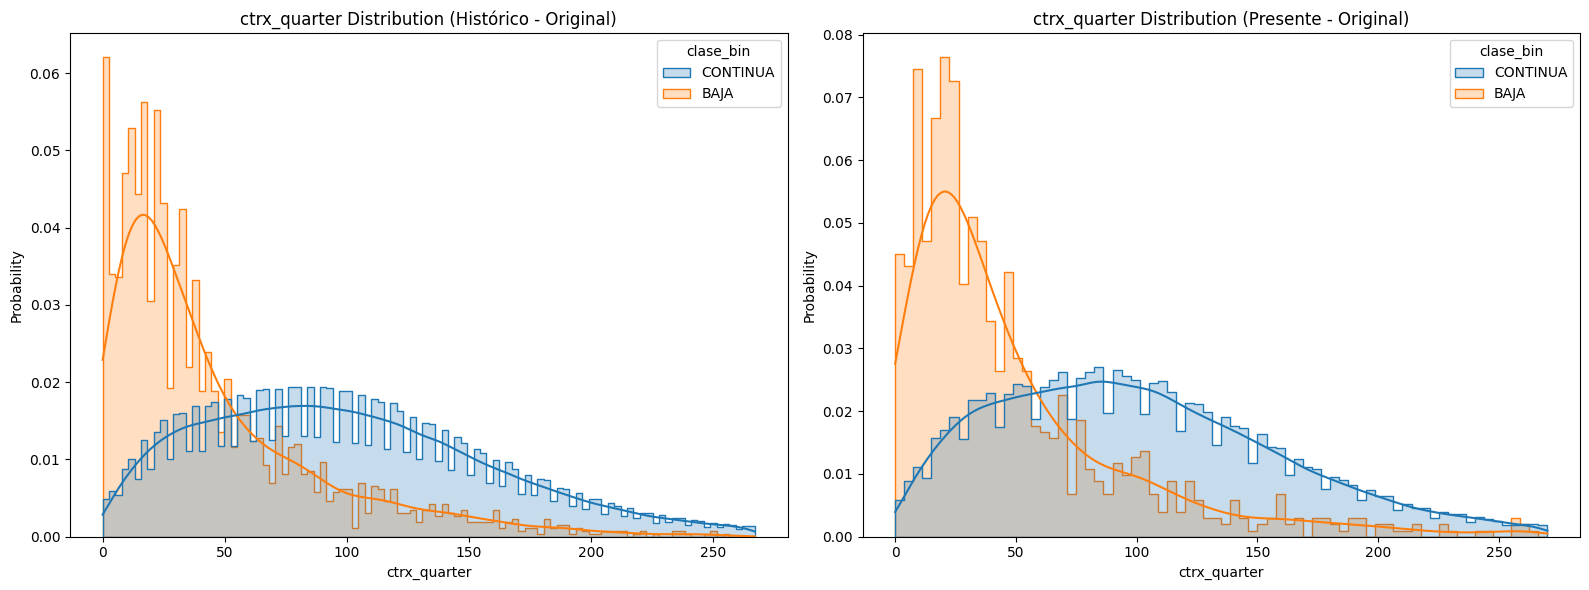

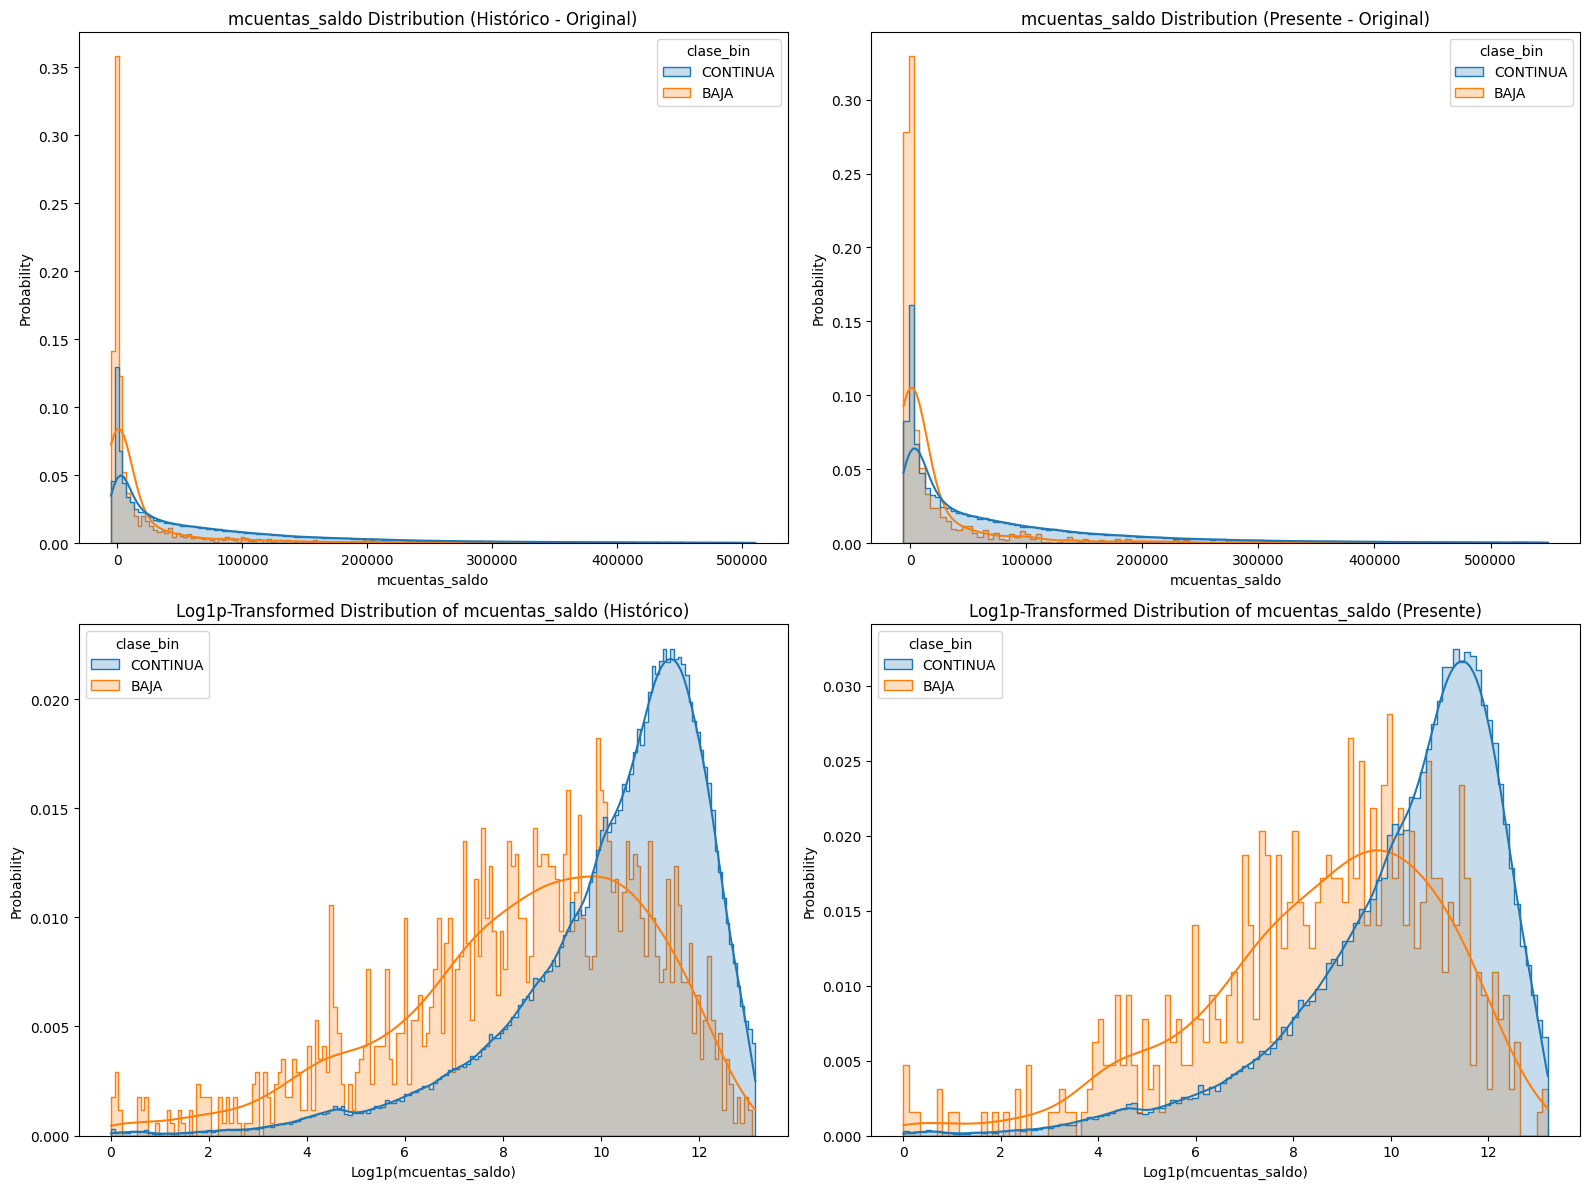

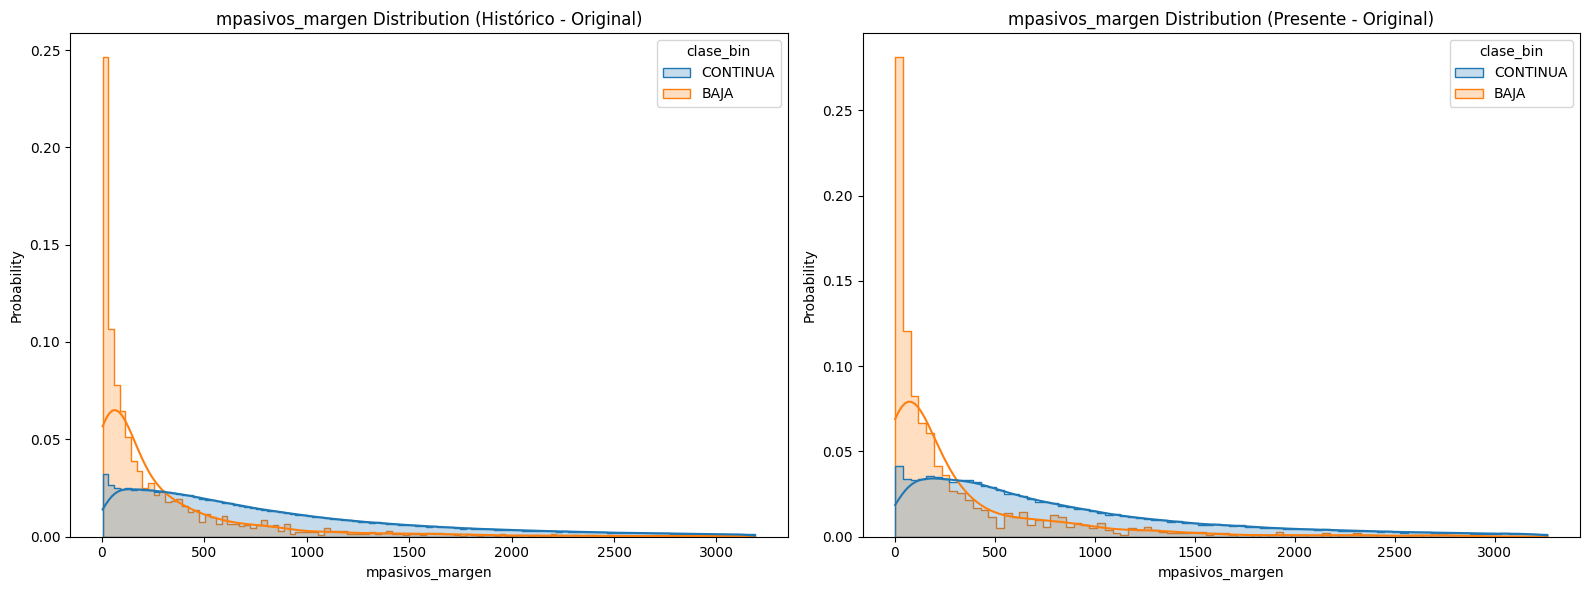

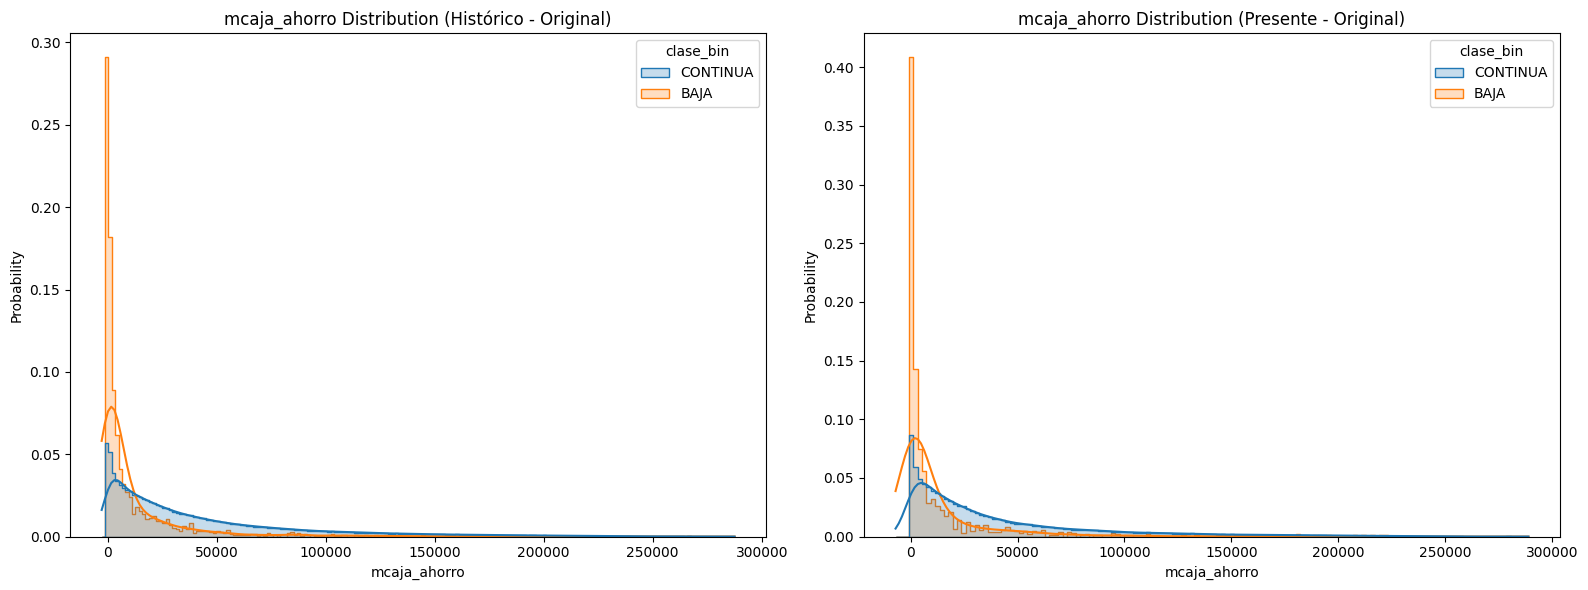

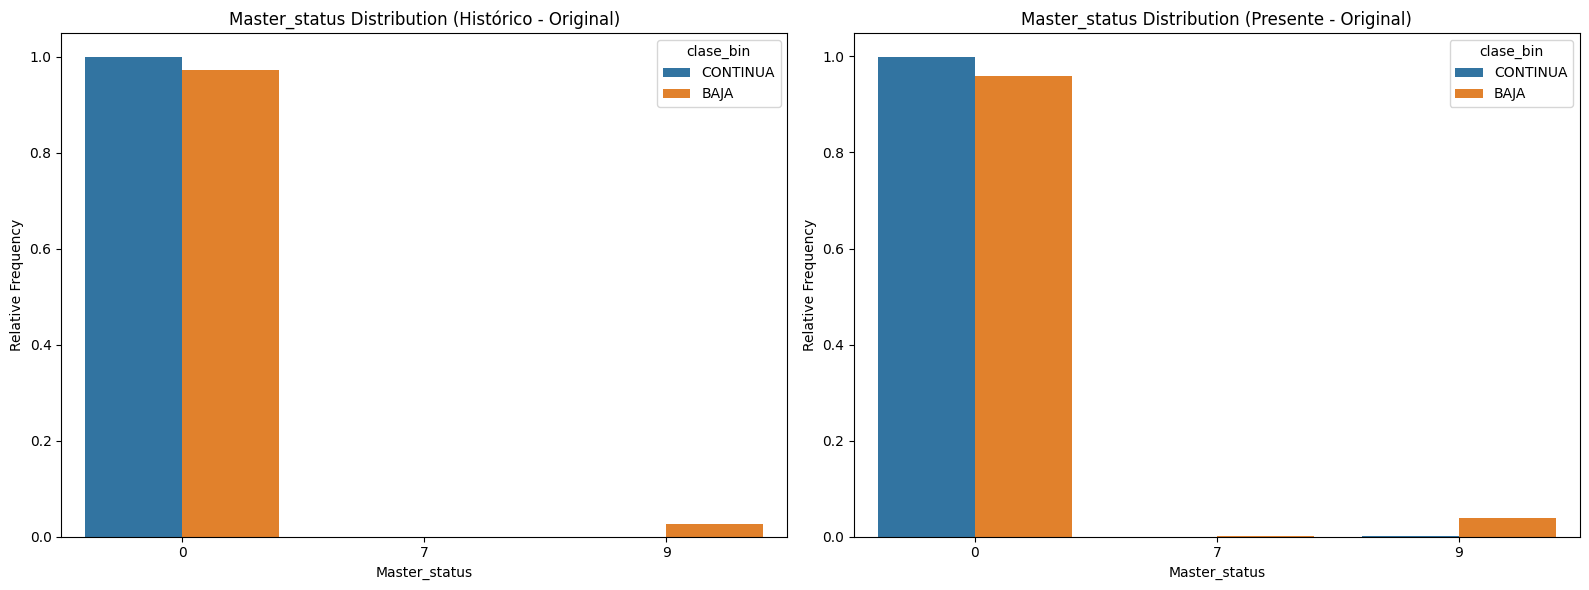

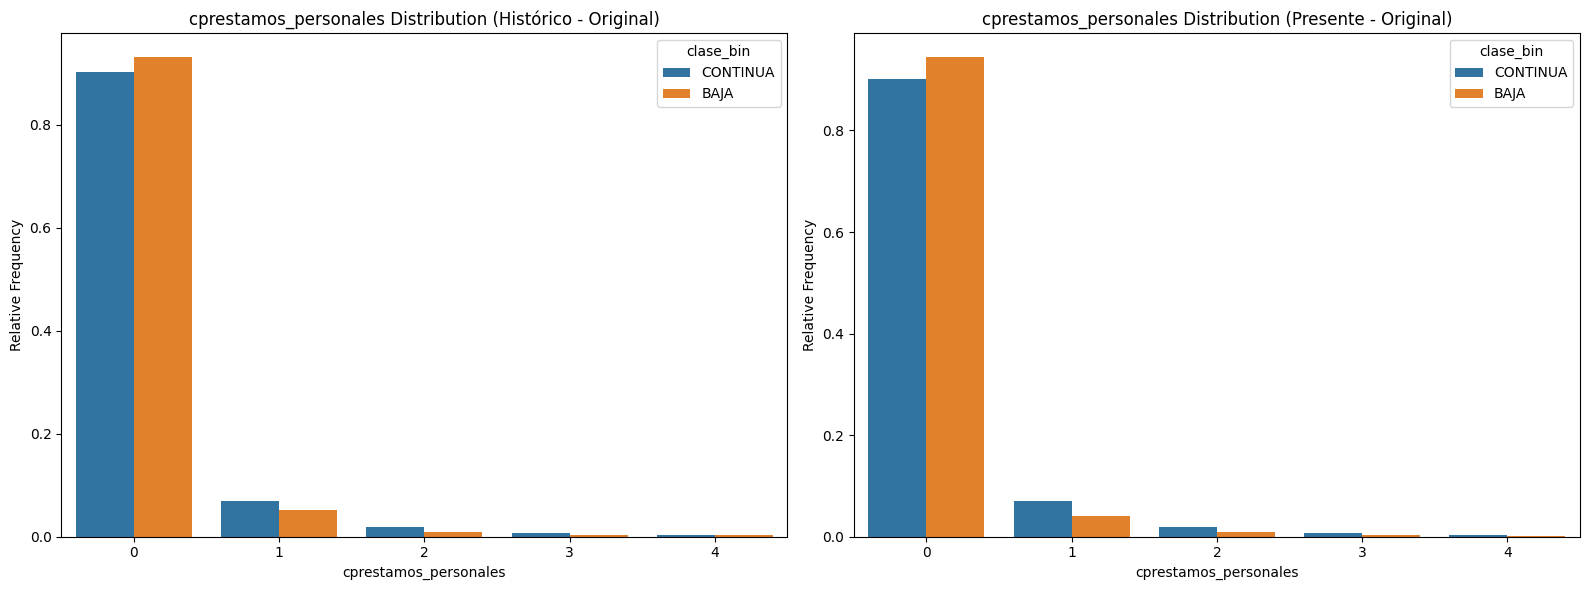

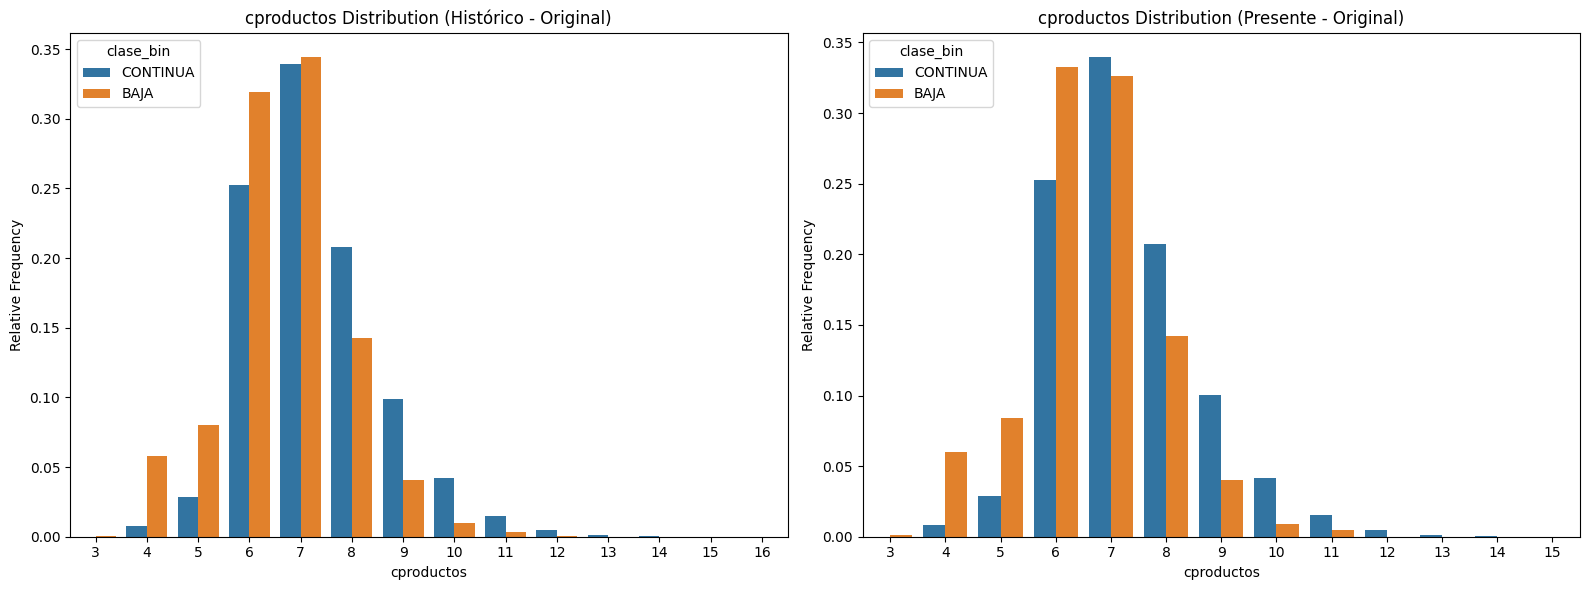

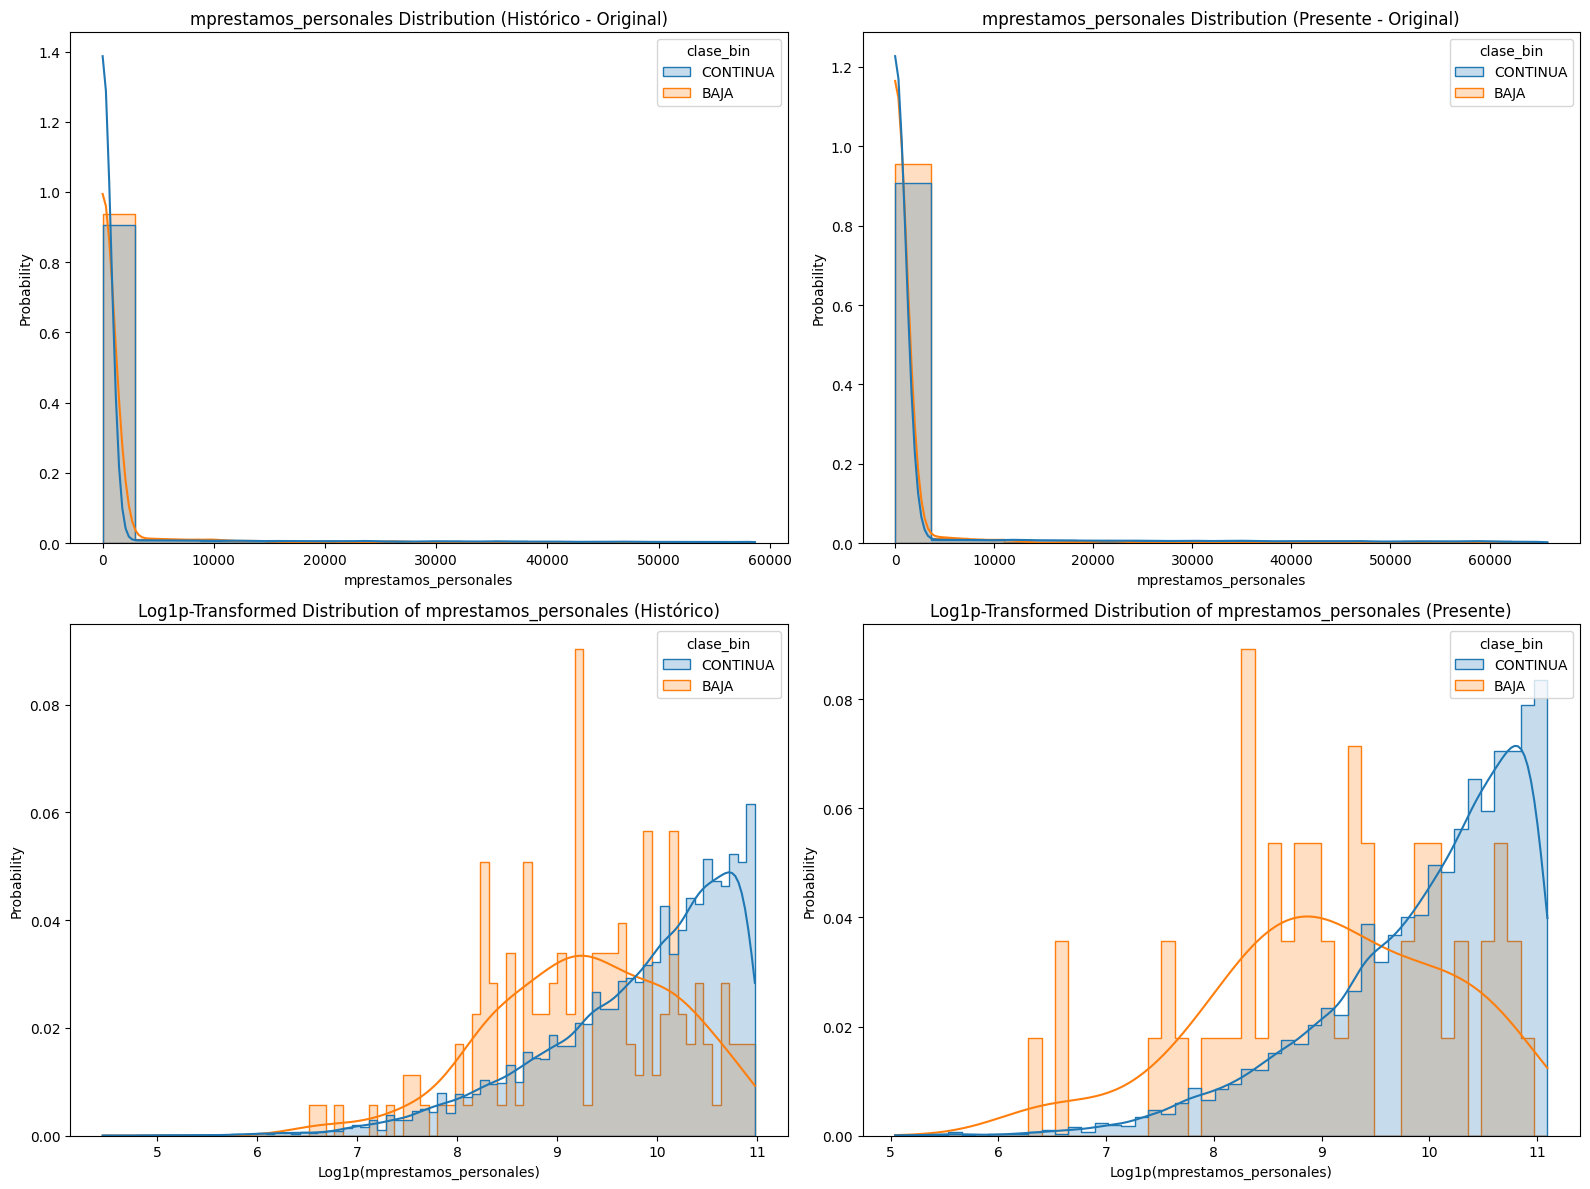

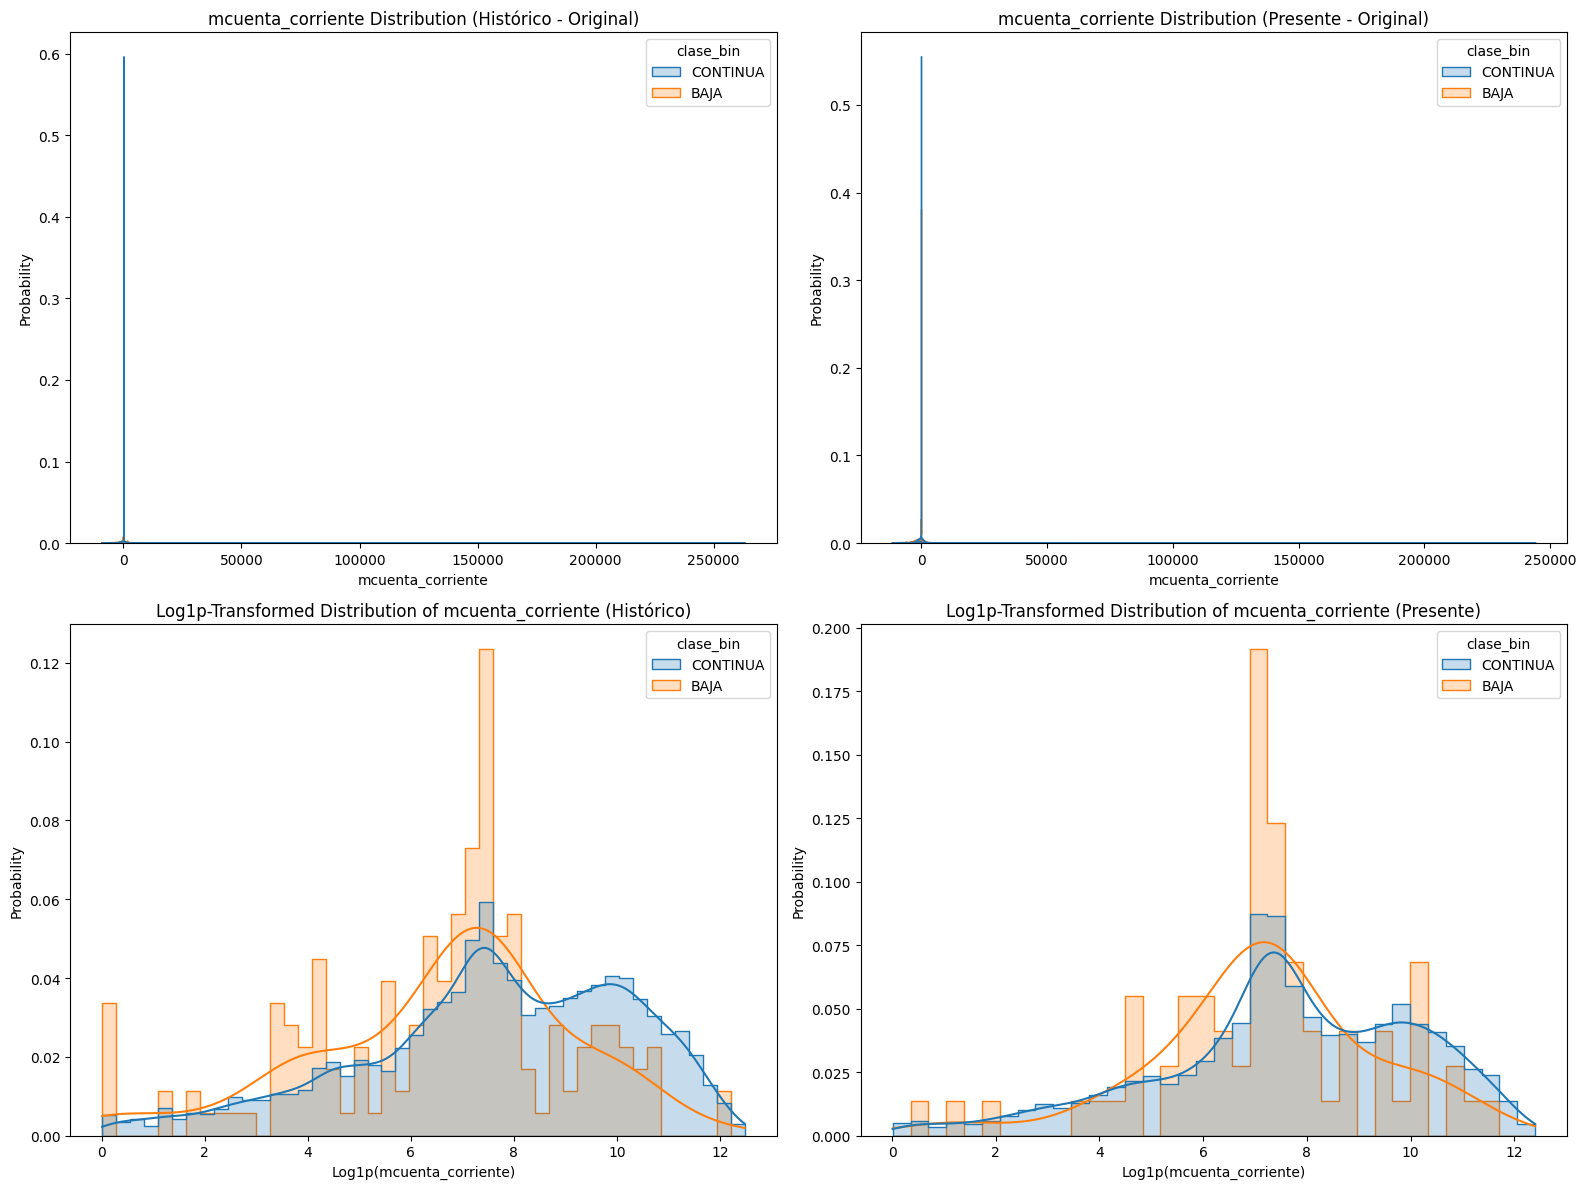

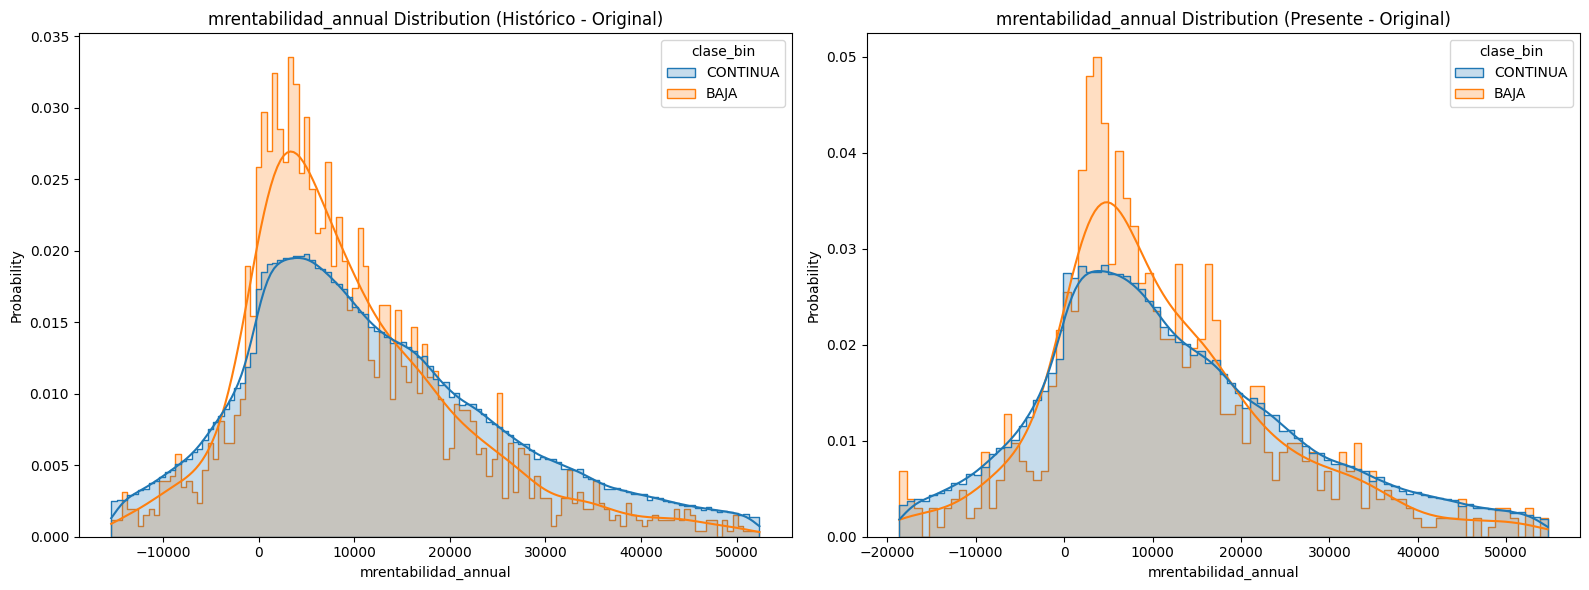

Matriz de Correlación - Comparativa


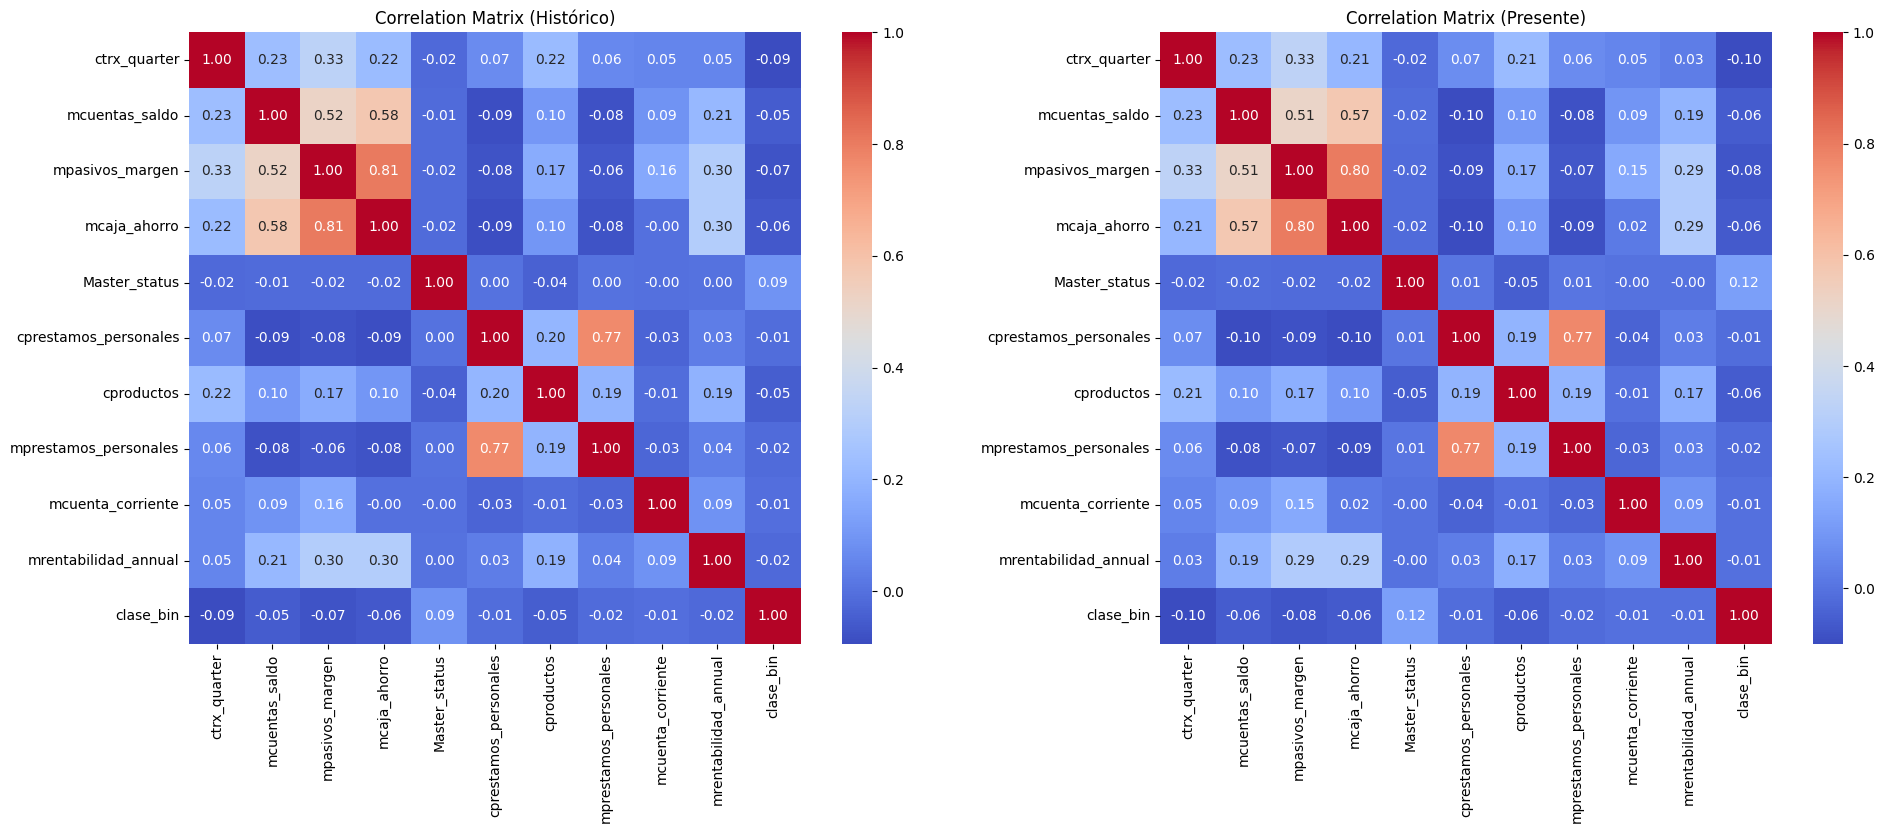

Valores Nulos - Comparativo
| Histórico   | Presente   |
|-------------|------------|


In [36]:
target = 'clase_bin'  # Tu variable objetivo

top_features_with_target = list(features.feature)[0:10] + [target]

# Selecting top columns
data_pres_top = data_pres[top_features_with_target]
data_hist_top = data_hist[top_features_with_target]

print("Resumen Estadístico - Comparativo")
key1= 'Hist'
key2= 'Pres'
summary_stats_combined = summary_statistics_comparative(data_hist_top, 
                                                        data_pres_top, 
                                                        key1, key2)
print(summary_stats_combined.to_markdown())

numeric_features = data_pres_top.select_dtypes(include=[np.number]).columns.tolist()

print("Distribución de Variables Numéricas - Comparativa")
plot_distributions_comparative(data_hist_top, data_pres_top, numeric_features, target=target, transform='log1p', sample_frac=1, to_log=to_log)

print("Matriz de Correlación - Comparativa")
plot_correlation_matrix_comparative(data_hist_top, data_pres_top, target=target)

print("Valores Nulos - Comparativo")
missing_values_combined = missing_values_analysis_comparative(data_hist_top, data_pres_top)
print(missing_values_combined.to_markdown())


# Nuevas variables

Luego de ejecutar la ingeniería de variables del Notebook_comp01_fe.ipynb

In [37]:
dataset_file = 'competencia_01_brandoni_fe.csv'

dataset_file = os.path.join(datos, dataset_file)

data = pd.read_csv(dataset_file)

In [38]:
# presente
data_pres = data[data['foto_mes'] == mes_test].copy()

# histórico
data_hist = data[data['foto_mes'] < mes_test].copy()

# all data sin últimos meses
data = data[data['foto_mes'] <= mes_test].copy()

In [39]:
X, y = def_xy(data_pres, mes_test)

In [40]:
# Entrenamiento del modelo de Random Forest
model_rf = RandomForestClassifier(n_estimators=100, 
                                  max_depth=10, 
                                  random_state=17)

X_imp = X.fillna(0)

model_rf.fit(X_imp, y)

RandomForestClassifier(max_depth=10, random_state=17)

In [41]:
import pickle

filename = 'modelos/model_rf_fe_eda.sav'

with open(filename, 'wb') as file:
    pickle.dump(model_rf, file)

print(f'Modelo guardado como {filename}')

Modelo guardado como modelos/model_rf_fe_eda.sav


In [42]:
filename = 'modelos/model_rf_fe_eda.sav'
model_rf = pickle.load(open(filename, 'rb'))

In [43]:
# Importancia de características con Random Forest
feature_importances_rf = pd.DataFrame({'feature': X.columns, 'importance': model_rf.feature_importances_})
feature_importances_rf.sort_values('importance', ascending=False, inplace=True)

In [47]:
feature_importances_rf

,feature,importance
156,saldo_total_completo,0.035873
107,ctrx_quarter,0.031081
22,mcuentas_saldo,0.022247
18,mcaja_ahorro,0.021105
169,prestamos_personales_10tile,0.020980
...,...,...
130,Master_cadelantosefectivo,0.000024
144,Visa_madelantodolares,0.000000
1,foto_mes,0.000000
121,Master_madelantopesos,0.000000


In [48]:
data['clase_bin'] = np.where(data['clase_ternaria'] == 'CONTINUA', 'CONTINUA', 'BAJA')

data_pres['clase_bin'] = np.where(data_pres['clase_ternaria'] == 'CONTINUA', 'CONTINUA', 'BAJA')

data_hist['clase_bin'] = np.where(data_hist['clase_ternaria'] == 'CONTINUA', 'CONTINUA', 'BAJA')

In [ ]:
### adaptación de variables, tipos de datos y transformaciones

### iterar para encontrar la mejor visualización de las variables más relevantes

Summary Statistics - All Data
|                             |   count |           mean |              std |               min |        25% |         50% |         75% |            max |
|:----------------------------|--------:|---------------:|-----------------:|------------------:|-----------:|------------:|------------:|---------------:|
| saldo_total_completo        |  652447 | 124753         | 297859           |      -2.06577e+06 | 25007.7    | 61499.7     | 131940      |    3.66379e+07 |
| ctrx_quarter                |  652447 |    118.399     |     87.8921      |       0           |    59      |   105       |    158      | 2425           |
| mcuentas_saldo              |  652447 | 206433         |      1.12012e+06 |      -3.08673e+06 |   763.595  | 34714.2     | 140830      |    1.86879e+08 |
| mcaja_ahorro                |  652447 |  78205.7       | 244682           |  -15048.5         |  5747.07   | 24048.2     |  70211.5    |    3.66379e+07 |
| prestamos_personales_10tile |  6

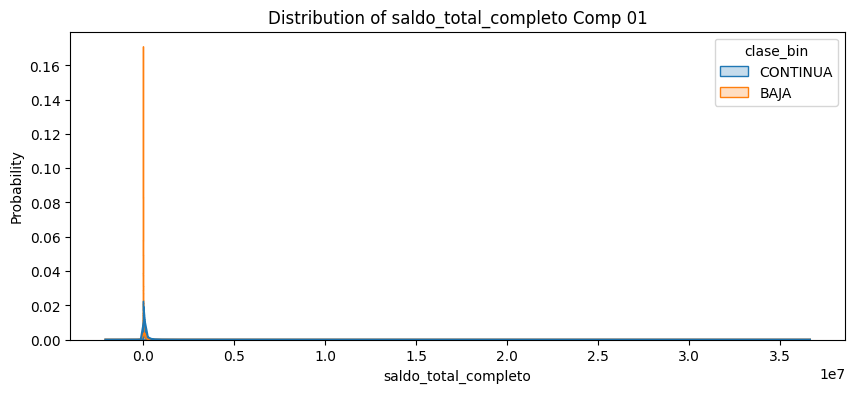

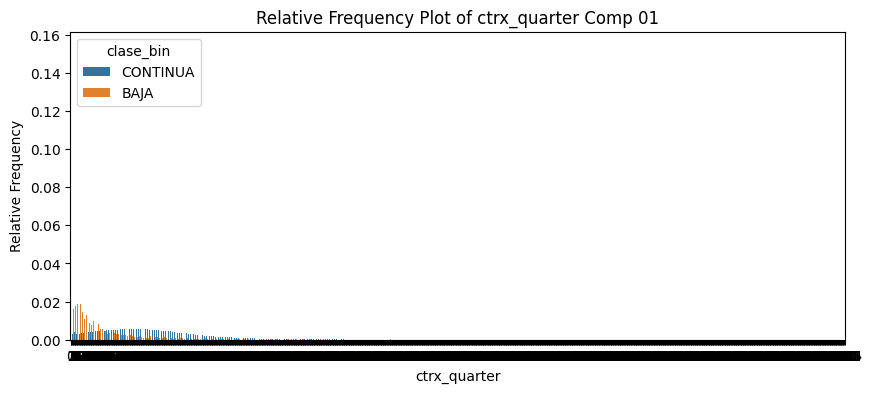

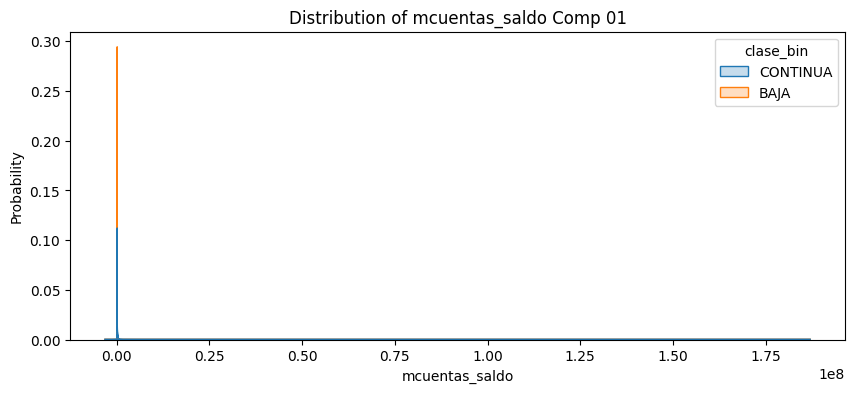

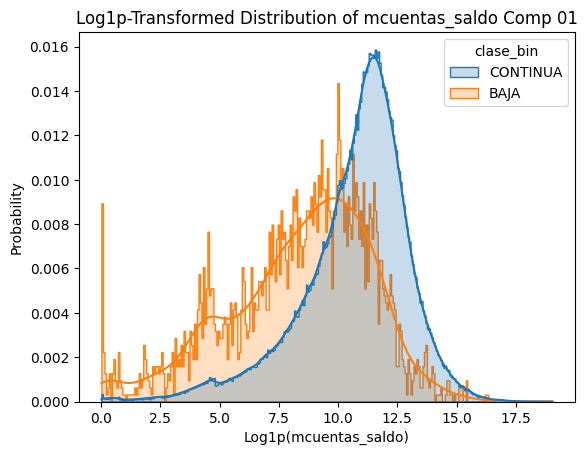

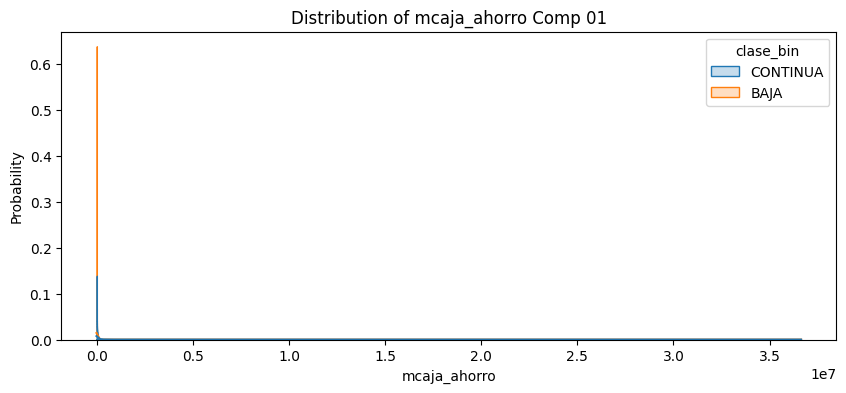

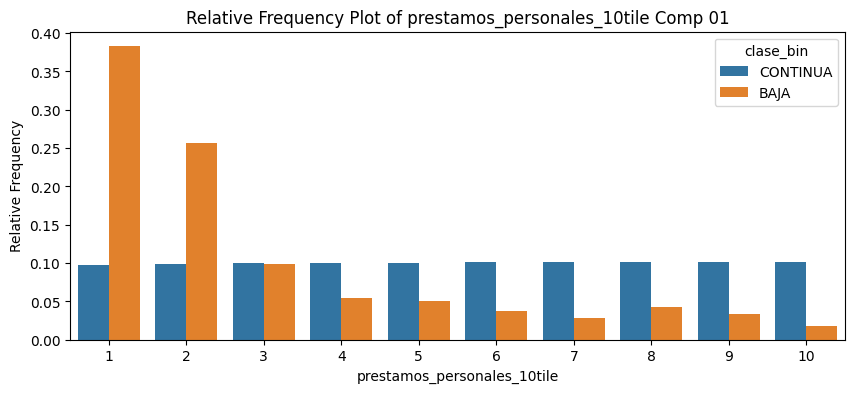

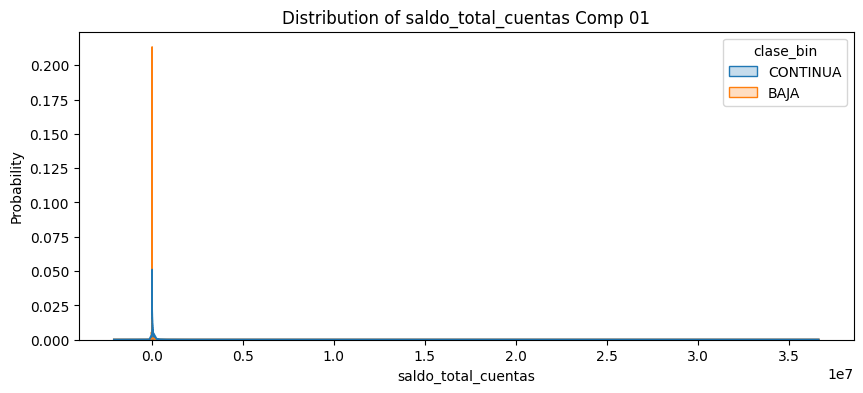

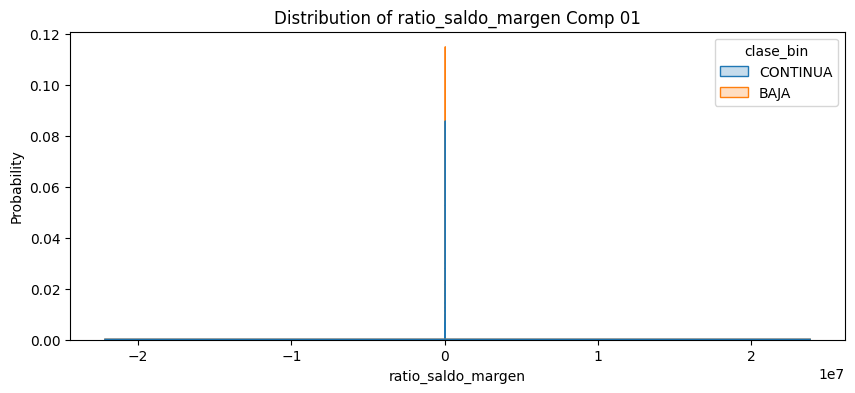

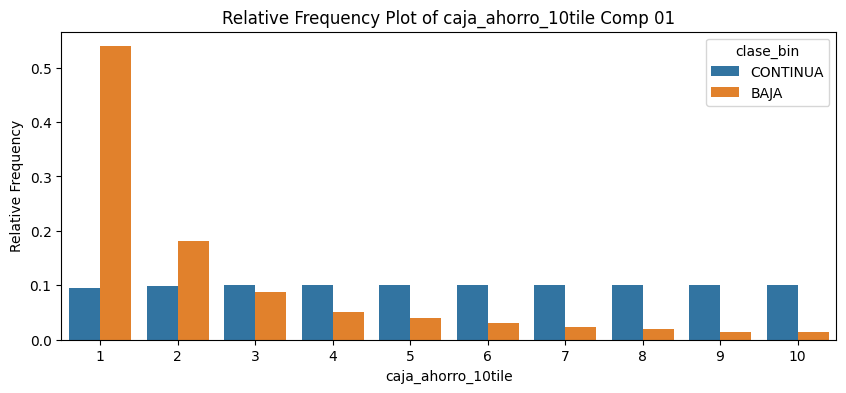

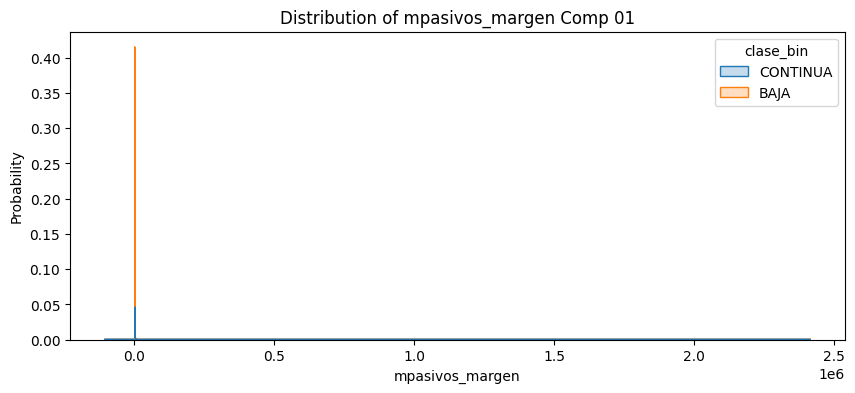

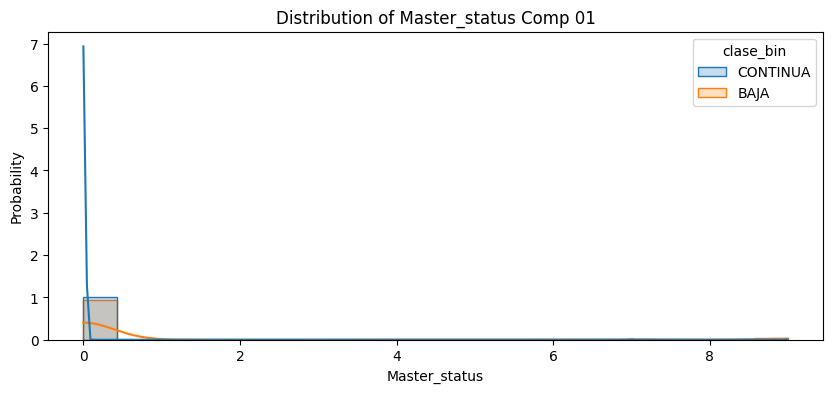

Correlation Matrix - 202104 Data


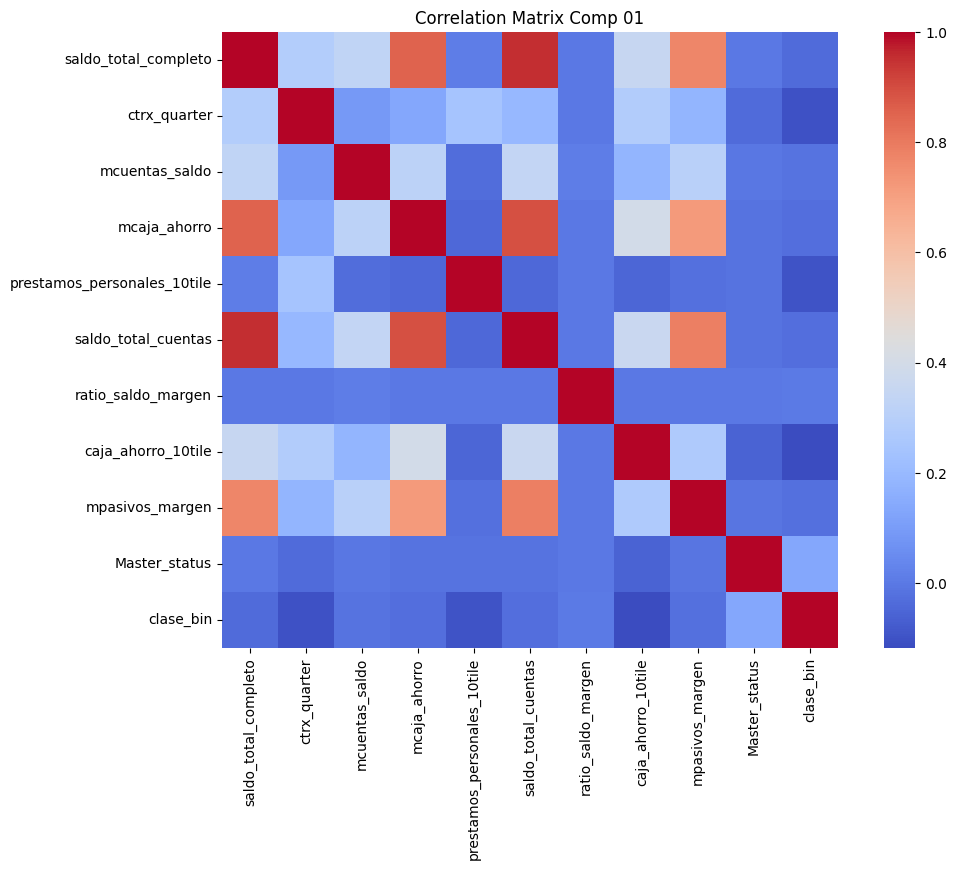

Missing Values - 202104 Data
Master_status         10.394254
ratio_saldo_margen     0.212125
dtype: float64


In [49]:
target = 'clase_bin'  # Your target variable

# Assuming you have your list of the top 10 original relevant variables + target
top_features_with_target = list(feature_importances_rf.feature)[:10] + [target]

# Selecting top columns
data_top = data[top_features_with_target]

# Summary statistics
print("Summary Statistics - All Data")
print(summary_statistics(data_top))
print()

print("Resumen Estadístico - Comparativo")
key1= 'BAJA'
key2= 'CONTINUA'
summary_stats_combined = summary_statistics_comparative(data_top.loc[data_top.clase_bin == key1], 
                                                        data_top.loc[data_top.clase_bin == key2], 
                                                        key1, key2)
print(summary_stats_combined.to_markdown())

# Distribution of numerical features
numeric_features = data_top.select_dtypes(include=[np.number]).columns.tolist()

print("Distribution of Numerical Features - All Data")
plot_distributions(data_top, numeric_features, 
                   target=target, title_suffix='Comp 01', 
                   transform='log1p', sample_frac=1, to_log=to_log)

# Correlation Matrix
print("Correlation Matrix - 202104 Data")
plot_correlation_matrix(data_top, target=target, title_suffix='Comp 01')

# Missing Values Analysis
print("Missing Values - 202104 Data")
print(missing_values_analysis(data_top))

# Segmentación de clientes

Luego de ejecutado el Notebook_comp01_segme.ipynb

In [ ]:
###

_____
_____